In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Feb  9 12:44:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Libraries

In [2]:
!pip install ipython-autotime
%load_ext autotime

time: 178 µs (started: 2022-02-09 12:44:43 +00:00)


In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

time: 6.84 ms (started: 2022-02-09 12:44:43 +00:00)


In [4]:
!pip install --quiet optuna

time: 2.82 s (started: 2022-02-09 12:44:43 +00:00)


In [5]:
import os
import pandas as pd
import numpy as np
import time
import datetime
import itertools
import glob
import re
from tqdm import tqdm
import math 
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')

from skimage import io
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras import backend as K
import keras 
from keras.utils.layer_utils import count_params

import optuna # hyeperparam optimization 

time: 2.88 s (started: 2022-02-09 12:44:46 +00:00)


# Variables

## Paths

In [6]:
root_dir ='/content/drive/MyDrive/@Projet datascientest/'
raw_data_dir = root_dir + 'RAW DATA/'
DL_dir = root_dir + 'DEEP LEARNING/' 

# export dir with time satmp
timestamp = datetime.datetime.now().strftime('%y%m%d_%HH%M')
export_dir = DL_dir + timestamp + '/'
os.makedirs(export_dir)
print(str(export_dir))

/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220209_12H44/
time: 7.78 ms (started: 2022-02-09 12:44:49 +00:00)


## Other

In [7]:
# seed
random_seed = 42

# resolution des images apres redimmensionnement (/!\ inversé par rapport à scikit)
resol = (240, 320) # (240, 320), [(24 , 32),(48 , 64),(72 , 96)]
# number of class to keep 
family_number = 7 # 7 pour comparaison Xgboost (acc = 0.32) & random 1/7 = 0.14
number_of_images = 5000 # None to get all images 
add_FRUIT360_images = False #add a class with 6000 images of 131 classes of fruit if true (kaggle dataset - 45 random images/class)


# epoch
epochs = 5 # 5 pour convergence 1st step
# learing rate 
learning_rate =1e-4 #1e-4 
# batch size 
batch_size = 16 # 16
# base model trainable 
base_model_trainable = True

# number of trials optuna
n_trials = 15 

#ZIP file with images 
raw_data_folder = 'RAW DATA.zip'
# raw_data_folder = 'RAW DATA FOR DEBUG.zip' # pour aller plus vite sur unzip 1400 images only 
# df with file_path 
csv_file_paths = 'image_and_json_data_DEBUG.csv' if raw_data_folder == 'RAW DATA FOR DEBUG.zip' else 'image_and_json_data.csv'

# DEBUG 
debug = False
one_image_per_class_only = False  # HARD DEBUG TO SEE if CNN learn
# epochs
number_of_images = 1000 if debug else number_of_images
epochs = 2 if debug else epochs
family_number = 3 if debug else family_number 


time: 8.92 ms (started: 2022-02-09 12:44:49 +00:00)


# Load & filter data

## Unzip images

In [8]:
# unzipping the file into the VM disk is SO much faster than reading each file individually from Drive
# cf https://stackoverflow.com/questions/59120853/google-colab-is-so-slow-while-reading-images-from-google-drive
main_path = "/content/"  + raw_data_folder.replace('.zip','') 
if os.path.exists(main_path)== False :
  if csv_file_paths == 'image_and_json_data_DEBUG.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA FOR DEBUG.zip' -d "/content"
  elif csv_file_paths == 'image_and_json_data.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA.zip' -d "/content"
else:
  print('ZIP already extracted')

ZIP already extracted
time: 3.83 ms (started: 2022-02-09 12:44:49 +00:00)


In [9]:
#FRUIT360 dataset pour créer un dataset sans champigons 
main_path = "/content/FRUIT360"
if os.path.exists(main_path)== False :
  if add_FRUIT360_images:
    !unzip '/content/drive/MyDrive/@Projet datascientest/FRUIT360.zip' -d "/content"

time: 1.14 ms (started: 2022-02-09 12:44:49 +00:00)


## File_path df

In [10]:
# df with path & target 
df_paths = pd.read_csv(root_dir + csv_file_paths)
print('{} rows in the file'.format(len(df_paths)))
df_paths .head()

215410 rows in the file


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6,9,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


file_name  ...            json_file
0  1208.jpg  ...  observations_0.json
1  1604.jpg  ...  observations_0.json
2  1608.jpg  ...  observations_0.json
3    29.jpg  ...  observations_0.json
4   680.jpg  ...  observations_0.json

[5 rows x 38 columns]

time: 1.97 s (started: 2022-02-09 12:44:49 +00:00)


In [11]:
# FRUIT360
if add_FRUIT360_images:
  # Trouver tous les chemins vers les fichiers qui finissent par .jpg
  liste = glob.glob('/content/FRUIT360/*/*.jpg')
  # Remplacer les \\ par /
  liste = list(map(lambda x : [x, x.split('/')[2]], liste))
  # Créer un DataFrame pandas
  df_FRUIT360  = pd.DataFrame(liste, columns=['drive_file_path', 'gbif_info.family'])
  display(df_FRUIT360.head())

time: 4.08 ms (started: 2022-02-09 12:44:51 +00:00)


In [12]:
# adjust paths for drive 
# SPECIFIC DRIVE lo laod image from content 
df_paths['drive_file_path'] =df_paths['file_path'].apply(lambda x: x.replace('C:/Users/thibe/Google Drive/@Projet datascientest',
                                              '/content')).apply(lambda x: x.replace('C:/Users/thibe/Google Drive/Projet datascientest',
                                              '/content')) # pas propre, remplacer par regex + re à l'occas 
df_paths['drive_file_path'] =df_paths['drive_file_path'].apply(lambda x: x.replace('\\','/'))
df_paths['drive_file_path']

0         /content/RAW DATA/IMAGES/2006/Agaricales/1208.jpg
1         /content/RAW DATA/IMAGES/2006/Agaricales/1604.jpg
2         /content/RAW DATA/IMAGES/2006/Agaricales/1608.jpg
3           /content/RAW DATA/IMAGES/2006/Agaricales/29.jpg
4            /content/RAW DATA/IMAGES/2006/Agaricus/680.jpg
                                ...                        
215405    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215406    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215407    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215408    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215409    /content/RAW DATA/IMAGES/2016/Zygomycota/59276...
Name: drive_file_path, Length: 215410, dtype: object

time: 267 ms (started: 2022-02-09 12:44:51 +00:00)


In [13]:
#select only 320,240 images with family info
df_paths = df_paths[df_paths['resolution']=='(320, 240)'] 

time: 166 ms (started: 2022-02-09 12:44:51 +00:00)


In [14]:
# drop na 
df_paths = df_paths[df_paths['gbif_info.family'].notna()]

time: 57.2 ms (started: 2022-02-09 12:44:51 +00:00)


In [15]:
# keep conf level over 90 
df_paths = df_paths.loc[df_paths['gbif_info.confidence']>90]

time: 55.8 ms (started: 2022-02-09 12:44:51 +00:00)


In [16]:
# keep only most common class
top_class = df_paths['gbif_info.class'].value_counts().index[0]
df_paths = df_paths[df_paths['gbif_info.class'] == top_class]
df_paths['gbif_info.class'].value_counts()

Agaricomycetes    74497
Name: gbif_info.class, dtype: int64

time: 58.8 ms (started: 2022-02-09 12:44:51 +00:00)


In [17]:
# Check number of classes 
pd.DataFrame(df_paths.groupby(['gbif_info.family'], as_index=False).size())

gbif_info.family  size
0          Agaricaceae  5254
1       Albatrellaceae   204
2          Amanitaceae  4769
3    Amylocorticiaceae    16
4      Amylostereaceae     6
..                 ...   ...
99         Tubariaceae   217
100     Tulasnellaceae    37
101    Tulostomataceae     2
102        Typhulaceae    44
103      Xenasmataceae    30

[104 rows x 2 columns]

time: 19.4 ms (started: 2022-02-09 12:44:52 +00:00)


In [18]:
# keep only top families 
top_fam = df_paths['gbif_info.family'].value_counts().index[:family_number].values
df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]

time: 35.3 ms (started: 2022-02-09 12:44:52 +00:00)


In [19]:
# ######### DEBUG LAST 3 FAMILLES TUOMR POUR INCLURE NO TUMOR ############
# # keep only top families 
# top_fam = df_paths['gbif_info.family'].value_counts().index.values[-3:]
# df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]
# #############################################

time: 1.59 ms (started: 2022-02-09 12:44:52 +00:00)


In [20]:
# reduce number or images if needed 
if number_of_images != None and not one_image_per_class_only: 
  df_paths,_ = train_test_split(df_paths,train_size=number_of_images,stratify=df_paths['gbif_info.family'],random_state=random_seed )
  print('{} rows in the file'.format(len(df_paths)))

5000 rows in the file
time: 74.2 ms (started: 2022-02-09 12:44:52 +00:00)


In [21]:
summary = df_paths.copy() #copy for later 
# summary.info()

time: 3.15 ms (started: 2022-02-09 12:44:52 +00:00)


In [22]:
# subset col of interest + label encoding
df = df_paths[['drive_file_path','gbif_info.family']].copy()
df['label'] = df['gbif_info.family'].replace(df['gbif_info.family'].unique(), [*range(len(df['gbif_info.family'].unique()))]).astype(str) # label encoding 

df.head()

drive_file_path  ... label
44369   /content/RAW DATA/IMAGES/2010/Russula vinacea/...  ...     0
172598  /content/RAW DATA/IMAGES/2015/Lactarius delici...  ...     0
184582  /content/RAW DATA/IMAGES/2015/Tylopilus felleu...  ...     1
211179  /content/RAW DATA/IMAGES/2016/Russula parazure...  ...     0
63243   /content/RAW DATA/IMAGES/2011/Psilocybe cyanes...  ...     2

[5 rows x 3 columns]

time: 29.2 ms (started: 2022-02-09 12:44:52 +00:00)


In [23]:
# concat with FRUIT360 
if add_FRUIT360_images:
  df_FRUIT360['label'] = df['label'].max() + 1 
  df = pd.concat([df,df_FRUIT360]).reset_index(drop=True)

time: 2.48 ms (started: 2022-02-09 12:44:52 +00:00)


In [24]:
# compute number of classes
print('number of rows = {}'.format(len(df['label'])))
dict_label_df = pd.DataFrame(df.groupby(['label','gbif_info.family'], as_index=False).size())
classes_count = len(dict_label_df)
dict_label_df

number of rows = 5000


label  gbif_info.family  size
0     0       Russulaceae   855
1     1        Boletaceae   847
2     2    Strophariaceae   628
3     3  Tricholomataceae   694
4     4       Amanitaceae   666
5     5       Agaricaceae   734
6     6    Cortinariaceae   576

time: 18.4 ms (started: 2022-02-09 12:44:52 +00:00)


In [25]:
# CREATE DICT LABELS 
dict_label = dict(dict_label_df[['label','gbif_info.family']].values)
dict_label

{'0': 'Russulaceae',
 '1': 'Boletaceae',
 '2': 'Strophariaceae',
 '3': 'Tricholomataceae',
 '4': 'Amanitaceae',
 '5': 'Agaricaceae',
 '6': 'Cortinariaceae'}

time: 6.45 ms (started: 2022-02-09 12:44:52 +00:00)


## Train/test split

In [26]:
#train/test 
df_train, df_test= train_test_split(df, train_size=0.8, stratify =df['label'], random_state=random_seed)
print(df_train.shape,df_test.shape)

(4000, 3) (1000, 3)
time: 12.5 ms (started: 2022-02-09 12:44:52 +00:00)


In [27]:
# compute a class weigts dict for unbalanced loss computation
# { cf https://qastack.fr/datascience/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras}
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes =np.unique(df_train['label']),y =df_train['label'])
class_weights = dict(enumerate(class_weights))

time: 5.28 ms (started: 2022-02-09 12:44:52 +00:00)


### Plot few images

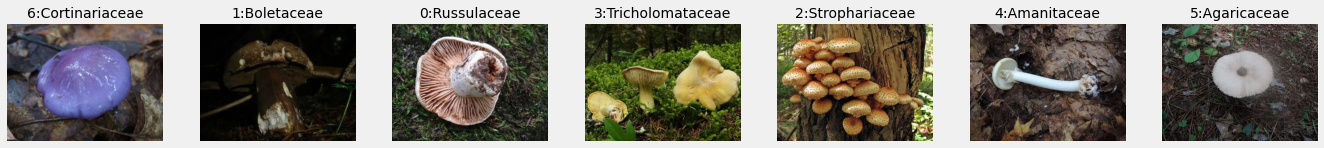

time: 425 ms (started: 2022-02-09 12:44:52 +00:00)


In [28]:
# first od each cat to check train/test
im_to_plot = df_train.groupby('label').head(1)
# plot
fig = plt.figure(figsize=(3*family_number,2))
j = 1 
for idx in im_to_plot.index:
  col_number = family_number
  row_number = 1
  ax = plt.subplot(row_number,col_number,j)
  im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
  plt.imshow(im)
  label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
  plt.title(label,size = 14)
  plt.axis('off')
  j +=1
fig.savefig(export_dir + str(resol) + '_first image of each family.jpeg' );

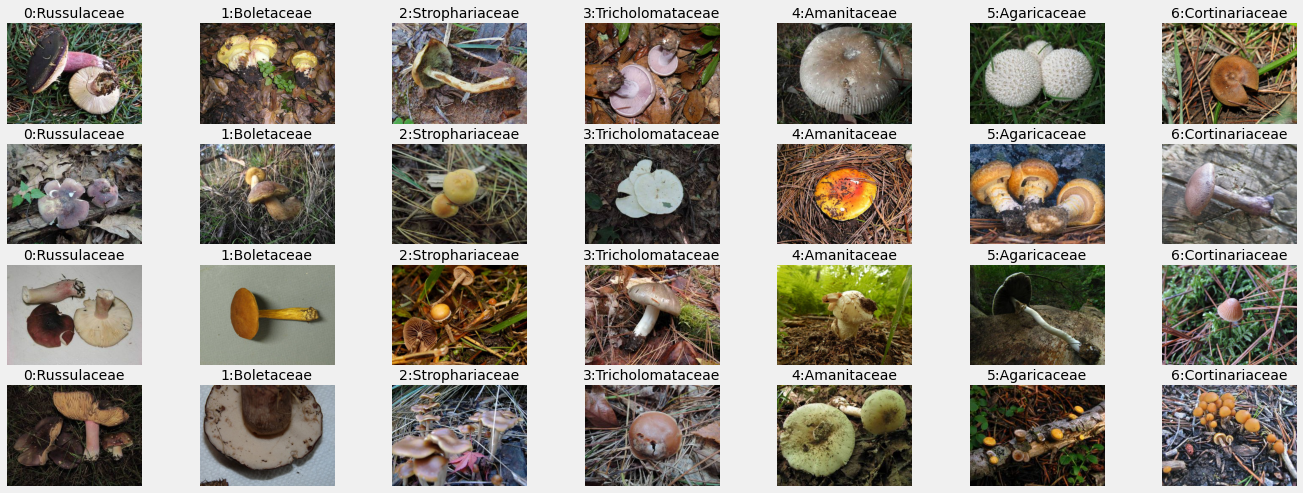

time: 1.47 s (started: 2022-02-09 12:44:52 +00:00)


In [29]:
# Plot random images de X_train (im_per_class per class)
im_per_class = 5 
#generate df with n image per class train set 
dfs_ = []
for n in range(im_per_class-1):
  df_ = df_train.groupby('label').apply(lambda x: x.sample(1))
  df_ = df_.droplevel(level=0)
  dfs_.append(df_)
im_to_plot = pd.concat(dfs_)
# plot
fig = plt.figure(figsize=(3*family_number,2*im_per_class))
j = 1 
for idx in im_to_plot.index:
  try:
    col_number = family_number
    row_number = im_per_class
    ax = plt.subplot(row_number,col_number,j)
    im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
    plt.imshow(im)
    label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
    plt.title(label,size = 14)
    plt.axis('off')
  except:
    continue
  j +=1
fig.savefig(export_dir + str(resol) + '_family examples.jpeg' );

# Fonctions & Callbacks

In [30]:
# model 
def define_model(model_name,base_model):
  base_model = base_model
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D() 
  dense1 = tf.keras.layers.Dense(units = 1024, activation = 'relu')
  dropout1 = tf.keras.layers.Dropout(0.3)
  dense2 = tf.keras.layers.Dense(units = 512, activation = 'relu')
  dropout2 = tf.keras.layers.Dropout(0.5)
  prediction_layer =  Dense(units = classes_count, activation = 'softmax')


  for layer in base_model.layers:
      layer.trainable = base_model_trainable

  model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    dense1, 
    dropout1,
    dense2,
    dropout2,
    prediction_layer
  ],
  name = model_name)
  return model



time: 10.8 ms (started: 2022-02-09 12:44:54 +00:00)


In [31]:
def plot_history(history,pathinfos):
  # train_acc_model = history['accuracy']
  # val_acc_model = history['val_accuracy']  

  fig = plt.figure(figsize=(20,5))

  plt.subplot(121)
  plt.plot(range(len(history['loss'])), history['loss'], '-o', label = "training")
  plt.plot(range(len(history['val_loss'])), history['val_loss'],  '-o',label = "validation")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title("Fonction de perte en fonction de l'epoch")
  plt.legend()

  plt.subplot(122)
  plt.plot(range(len(history['accuracy'])), history['accuracy'], '-o', label = "training")
  plt.plot(range(len(history['val_accuracy'])), history['val_accuracy'], '-o', label = "validation")
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.title("Accuracy en fonction de l'epoch")
  plt.legend();
  fig.suptitle(pathinfos + '_training history' ,size = 20 )
  fig.subplots_adjust(top=0.75)
  plt.close()
  return fig

time: 16 ms (started: 2022-02-09 12:44:54 +00:00)


In [32]:
def plot_history_2steps(history,pathinfos,max_epoch_freeze=None):
  # train_acc_model = history['accuracy']
  # val_acc_model = history['val_accuracy']  

  fig = plt.figure(figsize=(20,5))
  
  x = np.arange(1,(len(history['loss']))+1,1)
  plt.subplot(121)
  plt.plot(x, history['loss'], '-o', label = "training")
  plt.plot(x, history['val_loss'],  '-o',label = "validation")
  if max_epoch_freeze>0:
    plt.axvline(x=max_epoch_freeze, color = 'black')
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title("Fonction de perte en fonction de l'epoch")
  plt.legend()

  plt.subplot(122)
  plt.plot(x, history['accuracy'], '-o', label = "training")
  plt.plot(x, history['val_accuracy'], '-o', label = "validation")
  if max_epoch_freeze>0:
    plt.axvline(x=max_epoch_freeze, color = 'black' )
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.title("Accuracy en fonction de l'epoch")
  plt.legend();
  fig.suptitle(pathinfos + '_training history' ,size = 20 )
  fig.subplots_adjust(top=0.75)
  plt.close()
  return fig

time: 21.5 ms (started: 2022-02-09 12:44:54 +00:00)


In [33]:
def conf_matrix(y_test_class , test_pred_class,classes,df_label):
  ## Première étape, la matrice de confusion
  cnf_matrix = np.around(confusion_matrix(y_test_class , test_pred_class,normalize='pred'),2)*100

  ### Display a nice confusion matrix
  classes = range(0,(classes))
  fig = plt.figure(figsize=(15,5))

  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')

  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.grid(False)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, format(cnf_matrix[i, j],'.1f'),
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels (%)')
  plt.xlabel('Labels prédits (%)')

  #add label dict 
  lab_dict = 'label, family, count  \n\n '
  lab_dict = lab_dict + str(df_label.values).replace("[","").replace("]","")
  lab_dict = re.sub(r'([0-9]+) ', r'\1, ', lab_dict)
  lab_dict = re.sub(r'([A-Za-z0-9]+\')', r'\1,', lab_dict)
  plt.text(len(classes)+2, (len(classes)+2)/2, lab_dict)
  #TILTLE 
  title =  pathinfos + '\n Test=' + str(len(y_test_class)) + ' images'
  plt.title(title, size=18,y=1.12,x=1)


  # plt.show()
  plt.close()
  return fig

time: 40.6 ms (started: 2022-02-09 12:44:54 +00:00)


In [34]:
def conf_matrix_and_clasif_report(y_test_class , test_pred_class,classes,df_label):
  ## Première étape, la matrice de confusion
  cnf_matrix = np.around(confusion_matrix(y_test_class , test_pred_class,normalize='pred'),2)*100

  ### Display a nice confusion matrix
  classes = range(0,(classes))
  fig = plt.figure(figsize=(20,5))

  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')

  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.grid(False)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, format(cnf_matrix[i, j],'.1f'),
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels (%)')
  plt.xlabel('Labels prédits (%)')
  #add classif report 
  # plt.axvline(x=len(classes)+2, color = 'black')
  rep = metrics.classification_report(y_test_class, test_pred_class)
  plt.text(len(classes)+2.5, len(classes)+1, '|\n'*20, va='bottom')
  plt.text(len(classes)+3, len(classes)-1, rep)
  #add label dict 
  lab_dict = 'label, family, count  \n\n '
  lab_dict = lab_dict + str(df_label.values).replace("[","").replace("]","")
  lab_dict = re.sub(r'([0-9]+) ', r'\1, ', lab_dict)
  lab_dict = re.sub(r'([A-Za-z0-9]+\')', r'\1,', lab_dict)
  plt.text(len(classes)+11.5, len(classes)+1, '|\n'*20, va='bottom')
  plt.text(len(classes)+12, (len(classes)+2)/2, lab_dict)



  #TILTLE 
  title =  pathinfos + '\n Test=' + str(len(y_test_class)) + ' images'
  plt.title(title, size=18,y=1.12,x=1.7,ha = 'center')


  # plt.show()
  plt.close()
  return fig

time: 54.1 ms (started: 2022-02-09 12:44:54 +00:00)


In [35]:
# pour catcher la convergence lors de la première phase 
early_stopping_step1 = EarlyStopping(
                                patience=2, # Attendre 2 epochs avant application
                                min_delta = 0.01, # si au bout de 2 epochs la fonction de min_delta, 
                                 # que ce soit à la hausse ou à la baisse, on arrête
                                verbose=1, # Afficher à quel epoch on s'arrête
                                mode = 'auto',
                                monitor='val_accuracy')

early_stopping_step2 = EarlyStopping(
                                patience=3, # Attendre 5 epochs avant application
                                min_delta = 0.02, # si au bout de 4 epochs la fonction de min_delta, 
                                 # que ce soit à la hausse ou à la baisse, on arrête
                                verbose=1, # Afficher à quel epoch on s'arrête
                                mode = 'auto',
                                monitor='val_accuracy')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_accuracy",
                                    patience=2, #si val_accuracy stagne sur 3 epochs consécutives selon la valeur min_delta
                                    min_delta= 0.02,
                                    factor=0.1,  # On réduit le learning rate d'un facteur 0.1
                                    cooldown = 2, # On attend 2 epochs avant de réitérer 
                                    mode = 'auto',
                                    verbose=1)

time: 8.5 ms (started: 2022-02-09 12:44:54 +00:00)


# Training with Architecture EFB1 + FC 

## Dict of models 

In [36]:
export_dir

'/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220209_12H44/'

time: 2.83 ms (started: 2022-02-09 12:44:54 +00:00)


In [37]:
model_dict = {
    'EFB1' : tf.keras.applications.EfficientNetB1(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
    # 'EFB0' : tf.keras.applications.EfficientNetB0(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
    # 'MobileNetV3Large': tf.keras.applications.MobileNetV3Large(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
}

time: 3.12 s (started: 2022-02-09 12:44:54 +00:00)


## Choose model

In [38]:
# define model 
model_name  = 'EFB1'
base_model = model_dict[model_name]
# csv start path infos 
pathinfos = model_name + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(df_train)) + '_images'

time: 1.4 ms (started: 2022-02-09 12:44:57 +00:00)


In [39]:
# EN FIXANT architecture à 2 couches denses + 2 STEPS learning
#best architecture found using optuna cf cf trial 9 folder 220207_06H35 
trial_metric = {}
n_units_1, n_units_2 = 1024, 512
dropout_1, dropout_2 = 0.3 , 0.2 
lr = learning_rate # 1e-4 
batch_size = batch_size #16

time: 2.5 ms (started: 2022-02-09 12:44:57 +00:00)


## Train 1st step

In [40]:
# GENERATOR
# Clear clutter from previous TensorFlow graphs.
tf.keras.backend.clear_session()
# split train/val 
df_train_, df_val_= train_test_split(df_train, train_size=0.8, stratify =df_train['label'], random_state=random_seed)
# train datagenerator
train_data_generator = ImageDataGenerator(
                                        #   rotation_range=0.1, #trial.suggest_discrete_uniform('rotation_range', 0.0,0.2,0.1),
                                        #   # # width_shift_range=trial.suggest_discrete_uniform('width_shift_range', 0.0, 0.2,0.1),
                                        #   # # height_shift_range=trial.suggest_discrete_uniform('height_shift_range', 0.0, 0.2,0.1),
                                        #   # # shear_range=trial.suggest_discrete_uniform('shear_range=', 0.0, 0.2,0.1),
                                        #   # zoom_range=trial.suggest_discrete_uniform('zoom_range', 0.0, 0.2,0.1),
                                        #   horizontal_flip= True, # trial.suggest_categorical("horizontal_flip", [True,False]),
                                        #   vertical_flip= True # trial.suggest_categorical("vertical_flip", [True,False]),
                                        #   # # fill_mode='nearest',
                                        ) 
train_generator = train_data_generator.flow_from_dataframe(dataframe = df_train_, 
                                                          x_col = "drive_file_path",y_col="label", 
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')

#val datagenerator
val_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_val_,
                                                        x_col = "drive_file_path",y_col="label", 
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')

#test datagenerator w/o shuffle 
test_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_test,
                                                        x_col = "drive_file_path",y_col="label",shuffle=False,
                                                        target_size=resol,batch_size=batch_size,class_mode='sparse')

Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
Found 1000 validated image filenames belonging to 7 classes.
time: 71.3 ms (started: 2022-02-09 12:44:57 +00:00)


In [41]:
# on amene le modele à la fin de la premiere step d'entrainement 
# base model layers 
model_name  = 'EFB1'
weights = 'imagenet' # trial.suggest_categorical("weights", [None,'imagenet'])
base_model =  tf.keras.applications.EfficientNetB1(input_shape=(resol[0], resol[1], 3),
                                                    weights=weights,
                                                    include_top=False)
# base_model =base_model 
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() 
layers = [ base_model,  global_average_layer ]
# define a number of classifier layers 
layers.append(tf.keras.layers.Dense(units = n_units_1, activation = 'relu'))
layers.append(tf.keras.layers.Dropout(dropout_1))
layers.append(tf.keras.layers.Dense(units = n_units_2, activation = 'relu'))
layers.append(tf.keras.layers.Dropout(dropout_2))
# add predICTION layers 
layers.append(Dense(units = classes_count, activation = 'softmax'))
#freeze/unfreeze all layers 
for layer in base_model.layers:
    layer.trainable = False # unfreeze at start   
# build model        
model = tf.keras.Sequential(layers,name = model_name)
# optimizer 
optimizer = "adam" #  trial.suggest_categorical("optimizer", ["sgd", "adam"]) 
# compilation 
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
K.set_value(model.optimizer.learning_rate, lr) #set learning rate 
# csv start path infos 
pathinfos = str(model.name) + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(df_train)) + '_images'
## Entraînement
model.summary()
print('lr={}'.format(K.eval(model.optimizer.lr)))
training_history_model_1 = model.fit(train_generator,epochs=epochs,
                                steps_per_epoch = len(df_train_)//batch_size,
                                validation_data = val_generator,validation_steps = len(df_val_)//batch_size,
                                  class_weight=class_weights,
                                callbacks=[
                                            # early_stopping_step1, # pas dans un premier temps on veut convergence 
                                          #  reduce_learning_rate,  # pas dans un prmeier temps 
                                            ],
                                # use_multiprocessing = True,workers = 2 # pour warning tensorflow:Callback method on_train_batch_end is slow compared to the batch time
                                ) 

Model: "EFB1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 8, 10, 1280)      6575239   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                              

In [42]:
#save model h5 format sinon RAM issue whhen loaded from for loop !! 
model.save('/model_end_previous_step.h5')  # /model_first_step.h5

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


time: 513 ms (started: 2022-02-09 12:46:46 +00:00)


# Optuna for fine tuning step

## Nombre de couches et lrscheduler

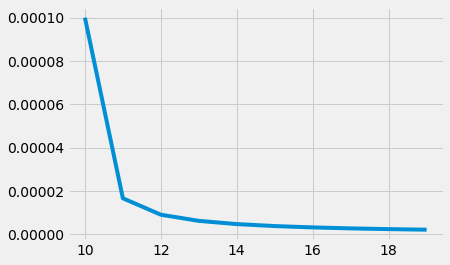

time: 163 ms (started: 2022-02-09 12:46:47 +00:00)


In [43]:
# lr scheduler inspired from # FROM https://colab.research.google.com/notebooks/tpu.ipynb#scrollTo=iXJXG-Ufdbnu
#and https://keras.io/api/callbacks/learning_rate_scheduler/

#time decay scheduler : lr * 1 / (1 + decay * epoch-max_epoch_freeze)
#step decay scheduler : lr*decay_rate**((epoch-max_epoch_freeze )//drop_period)
#exponetial :learning_rate = initial_lr * e^(−k * epoch)
max_epoch_freeze = 10
decay_rate = 5 # [0.1, 2] pour time based 
def scheduler(epoch,lr,decay_rate):
  return lr * 1 / (1 + decay_rate * (epoch-max_epoch_freeze))
rang = np.arange(max_epoch_freeze,20)
y = [scheduler(x,learning_rate,decay_rate) for x in rang]
plt.plot(rang, y)

[I 2022-02-09 12:46:47,712] A new study created in memory with name: no-name-a3d74ab9-f0fc-471b-935a-619438b662fd


************************************************************************************************************************
trial 0:{'lr_2nd_step': 1.0802987253291648e-06, 'decay_rate': 7.0, 'layer_unfreeze': 310.0}
**************************************************setting base model trainable**************************************************
**************************************************setting base model trainable**************************************************
trainable_count = 8288507 / non_trainable_count =  126867
0.001
1.0802987253291648e-06
lr=1.080298716260586e-06 / batch_size = 16
Epoch 6/15
200/200 [==============================] - 64s 264ms/step - loss: 1.1263 - accuracy: 0.5984 - val_loss: 1.2005 - val_accuracy: 0.5625 - lr: 1.0803e-06
Epoch 7/15
200/200 [==============================] - 45s 226ms/step - loss: 1.0430 - accuracy: 0.6359 - val_loss: 1.1944 - val_accuracy: 0.5612 - lr: 1.3504e-07
Epoch 8/15
200/200 [==============================] - 45s 226ms/step - loss

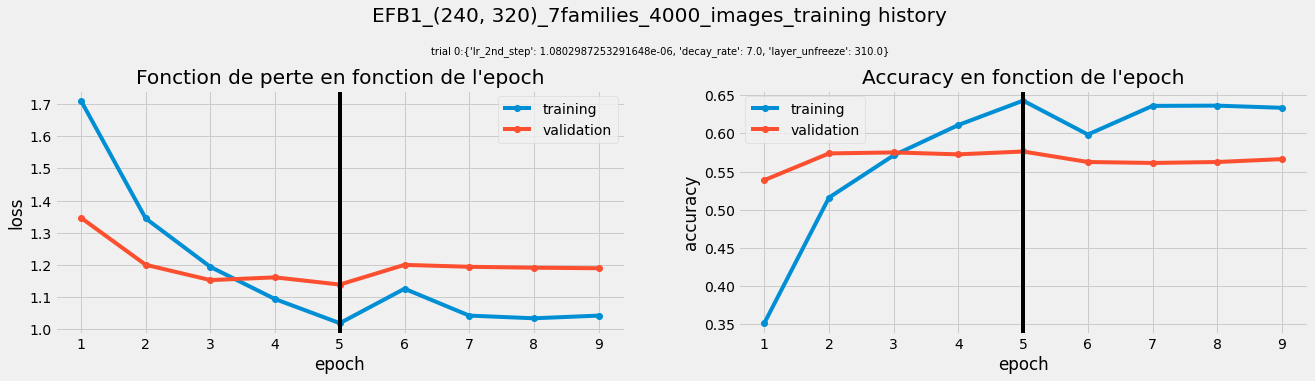

**************************************************TEST set classification report**************************************************


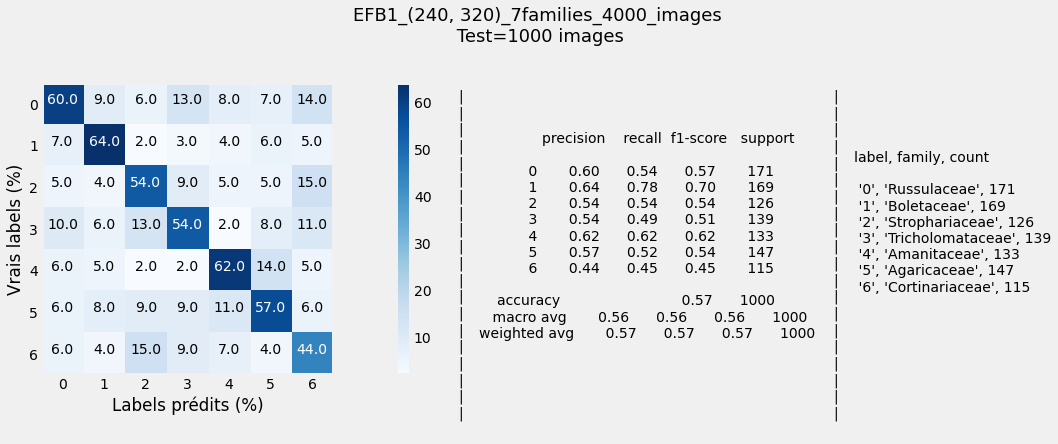

[I 2022-02-09 12:52:35,194] Trial 0 finished with value: 0.5662500262260437 and parameters: {'lr_2nd_step': 1.0802987253291648e-06, 'decay_rate': 7.0, 'layer_unfreeze': 310.0}. Best is trial 0 with value: 0.5662500262260437.


************************************************************************************************************************
trial 1:{'lr_2nd_step': 1.0002744217847232e-05, 'decay_rate': 2.0, 'layer_unfreeze': 340.0}
**************************************************setting base model trainable**************************************************
**************************************************setting base model trainable**************************************************
trainable_count = 8291271 / non_trainable_count =  124103
0.001
1.0002744217847232e-05
lr=1.0002744602388702e-05 / batch_size = 16
Epoch 6/15
200/200 [==============================] - 73s 314ms/step - loss: 0.9739 - accuracy: 0.6550 - val_loss: 1.1378 - val_accuracy: 0.5700 - lr: 1.0003e-05
Epoch 7/15
200/200 [==============================] - 61s 304ms/step - loss: 0.8474 - accuracy: 0.7094 - val_loss: 1.1314 - val_accuracy: 0.5750 - lr: 3.3342e-06
Epoch 8/15
200/200 [==============================] - 61s 305ms/step - los

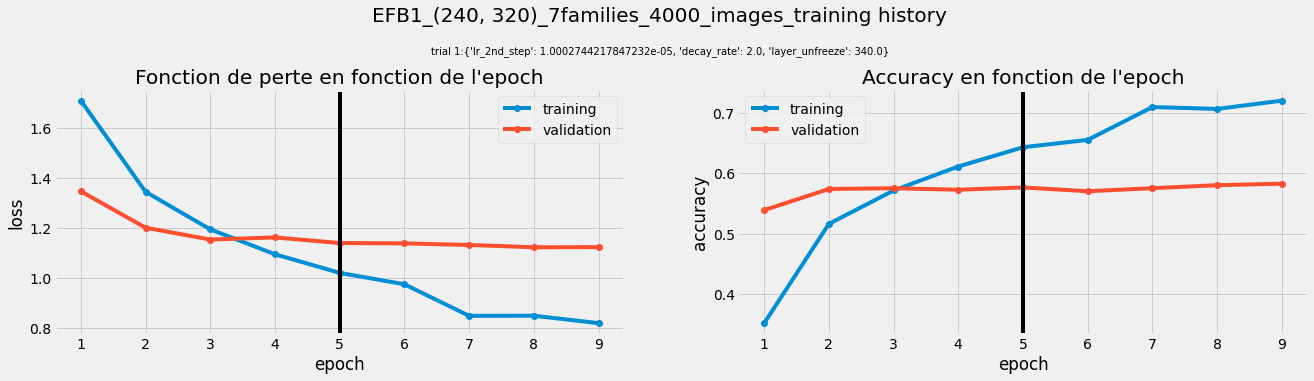

**************************************************TEST set classification report**************************************************


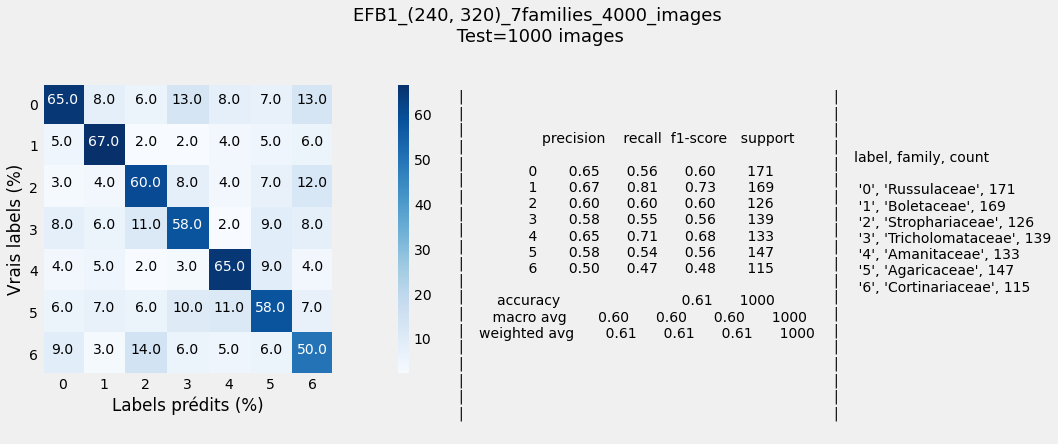

[I 2022-02-09 12:58:02,763] Trial 1 finished with value: 0.5824999809265137 and parameters: {'lr_2nd_step': 1.0002744217847232e-05, 'decay_rate': 2.0, 'layer_unfreeze': 340.0}. Best is trial 1 with value: 0.5824999809265137.


************************************************************************************************************************
trial 2:{'lr_2nd_step': 4.315481429386717e-06, 'decay_rate': 7.0, 'layer_unfreeze': 340.0}
**************************************************setting base model trainable**************************************************
**************************************************setting base model trainable**************************************************
trainable_count = 8291271 / non_trainable_count =  124103
0.001
4.315481429386717e-06
lr=4.315481419325806e-06 / batch_size = 16
Epoch 6/15
200/200 [==============================] - 73s 315ms/step - loss: 1.0415 - accuracy: 0.6331 - val_loss: 1.1493 - val_accuracy: 0.5875 - lr: 4.3155e-06
Epoch 7/15
200/200 [==============================] - 61s 306ms/step - loss: 0.9275 - accuracy: 0.6825 - val_loss: 1.1448 - val_accuracy: 0.5788 - lr: 5.3944e-07
Epoch 8/15
200/200 [==============================] - 61s 306ms/step - loss: 

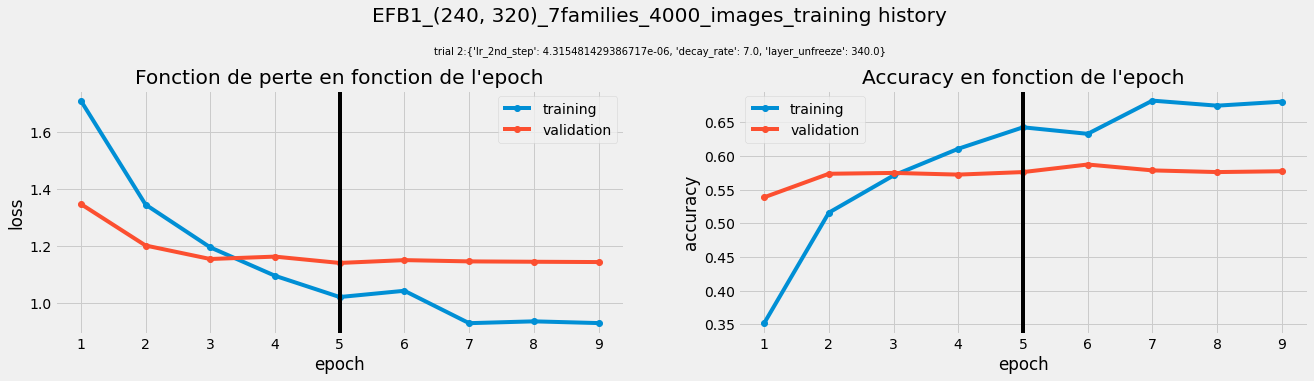

**************************************************TEST set classification report**************************************************


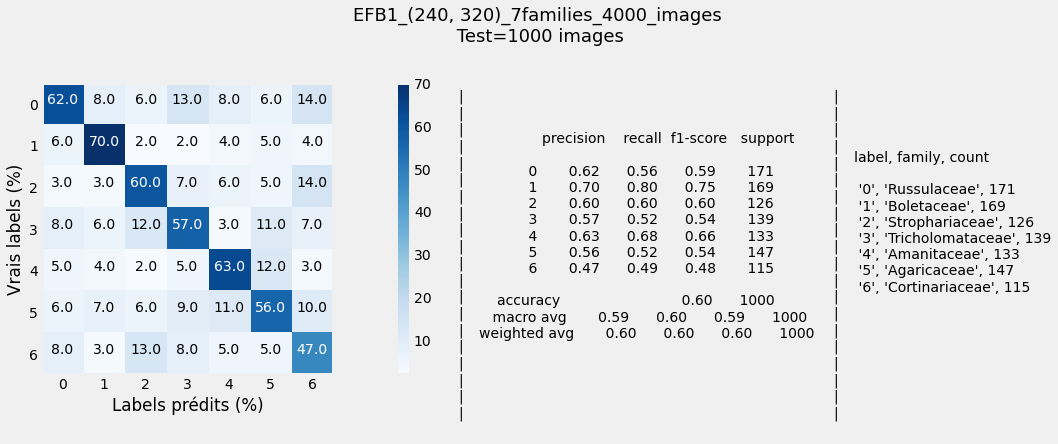

[I 2022-02-09 13:03:51,009] Trial 2 finished with value: 0.5774999856948853 and parameters: {'lr_2nd_step': 4.315481429386717e-06, 'decay_rate': 7.0, 'layer_unfreeze': 340.0}. Best is trial 1 with value: 0.5824999809265137.


************************************************************************************************************************
trial 3:{'lr_2nd_step': 1.821425914472297e-06, 'decay_rate': 8.0, 'layer_unfreeze': 310.0}
**************************************************setting base model trainable**************************************************
**************************************************setting base model trainable**************************************************
trainable_count = 8288507 / non_trainable_count =  126867
0.001
1.821425914472297e-06
lr=1.8214259398519062e-06 / batch_size = 16
Epoch 6/15
200/200 [==============================] - ETA: 0s - loss: 1.0823 - accuracy: 0.6166

[I 2022-02-09 13:04:52,687] Trial 3 pruned. Trial was pruned at epoch 5.


************************************************************************************************************************
trial 4:{'lr_2nd_step': 1.583191730945468e-05, 'decay_rate': 7.0, 'layer_unfreeze': 280.0}
**************************************************setting base model trainable**************************************************
**************************************************setting base model trainable**************************************************
trainable_count = 8269393 / non_trainable_count =  145981
0.001
1.583191730945468e-05
lr=1.5831918062758632e-05 / batch_size = 16
Epoch 6/15
200/200 [==============================] - ETA: 0s - loss: 0.9875 - accuracy: 0.6516

[I 2022-02-09 13:05:44,098] Trial 4 pruned. Trial was pruned at epoch 5.


************************************************************************************************************************
trial 5:{'lr_2nd_step': 1.2742290598871015e-06, 'decay_rate': 7.0, 'layer_unfreeze': 280.0}
**************************************************setting base model trainable**************************************************
**************************************************setting base model trainable**************************************************
trainable_count = 8269393 / non_trainable_count =  145981
0.001
1.2742290598871015e-06
lr=1.2742290209644125e-06 / batch_size = 16
Epoch 6/15
200/200 [==============================] - ETA: 0s - loss: 1.1240 - accuracy: 0.6062

[I 2022-02-09 13:06:35,598] Trial 5 pruned. Trial was pruned at epoch 5.


************************************************************************************************************************
trial 6:{'lr_2nd_step': 9.482337236420842e-05, 'decay_rate': 10.0, 'layer_unfreeze': 250.0}
**************************************************setting base model trainable**************************************************
**************************************************setting base model trainable**************************************************
trainable_count = 8238469 / non_trainable_count =  176905
0.001
9.482337236420842e-05
lr=9.482337191002443e-05 / batch_size = 16
Epoch 6/15
200/200 [==============================] - 41s 156ms/step - loss: 1.0837 - accuracy: 0.6134 - val_loss: 1.0923 - val_accuracy: 0.5875 - lr: 9.4823e-05
Epoch 7/15
200/200 [==============================] - 29s 146ms/step - loss: 0.6623 - accuracy: 0.7959 - val_loss: 1.0497 - val_accuracy: 0.6187 - lr: 8.6203e-06
Epoch 8/15
200/200 [==============================] - 29s 147ms/step - loss:

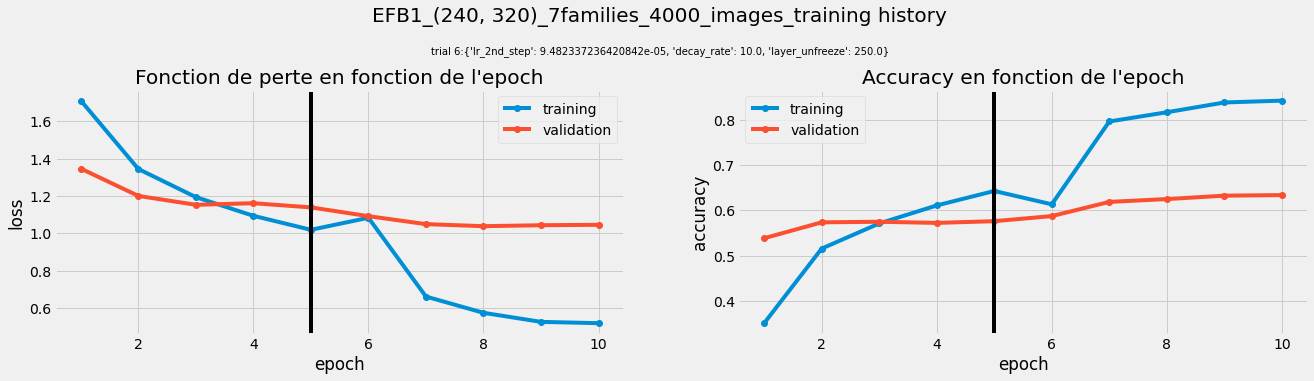

**************************************************TEST set classification report**************************************************


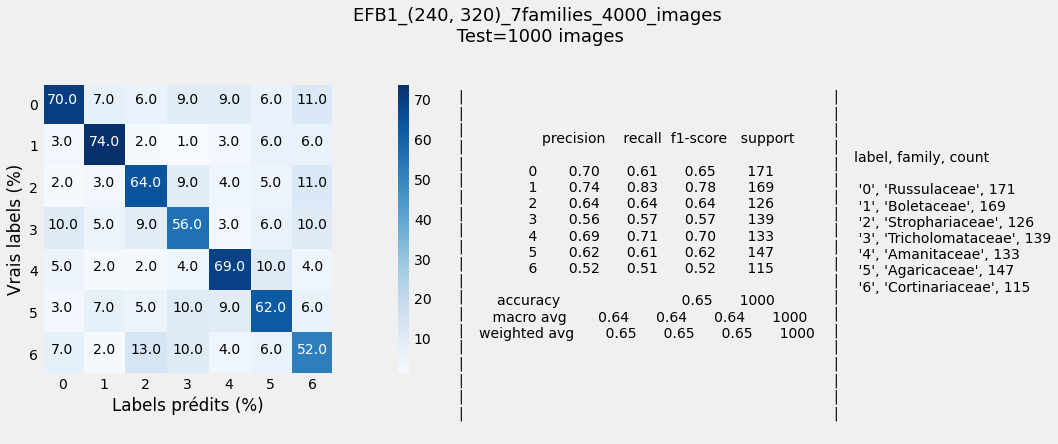

[I 2022-02-09 13:10:19,968] Trial 6 finished with value: 0.6337500214576721 and parameters: {'lr_2nd_step': 9.482337236420842e-05, 'decay_rate': 10.0, 'layer_unfreeze': 250.0}. Best is trial 6 with value: 0.6337500214576721.


************************************************************************************************************************
trial 7:{'lr_2nd_step': 2.3092477374746204e-05, 'decay_rate': 8.0, 'layer_unfreeze': 250.0}
**************************************************setting base model trainable**************************************************
**************************************************setting base model trainable**************************************************
trainable_count = 8238469 / non_trainable_count =  176905
0.001
2.3092477374746204e-05
lr=2.3092477931641042e-05 / batch_size = 16
Epoch 6/15
200/200 [==============================] - ETA: 0s - loss: 1.0034 - accuracy: 0.6456

[I 2022-02-09 13:11:05,222] Trial 7 pruned. Trial was pruned at epoch 5.


************************************************************************************************************************
trial 8:{'lr_2nd_step': 4.495828846126947e-05, 'decay_rate': 2.0, 'layer_unfreeze': 250.0}
**************************************************setting base model trainable**************************************************
**************************************************setting base model trainable**************************************************
trainable_count = 8238469 / non_trainable_count =  176905
0.001
4.495828846126947e-05
lr=4.495828761719167e-05 / batch_size = 16
Epoch 6/15
200/200 [==============================] - 41s 156ms/step - loss: 1.0005 - accuracy: 0.6350 - val_loss: 1.1098 - val_accuracy: 0.5888 - lr: 4.4958e-05
Epoch 7/15
200/200 [==============================] - 29s 147ms/step - loss: 0.7348 - accuracy: 0.7484 - val_loss: 1.0809 - val_accuracy: 0.6175 - lr: 1.4986e-05
Epoch 8/15
200/200 [==============================] - 29s 147ms/step - loss: 

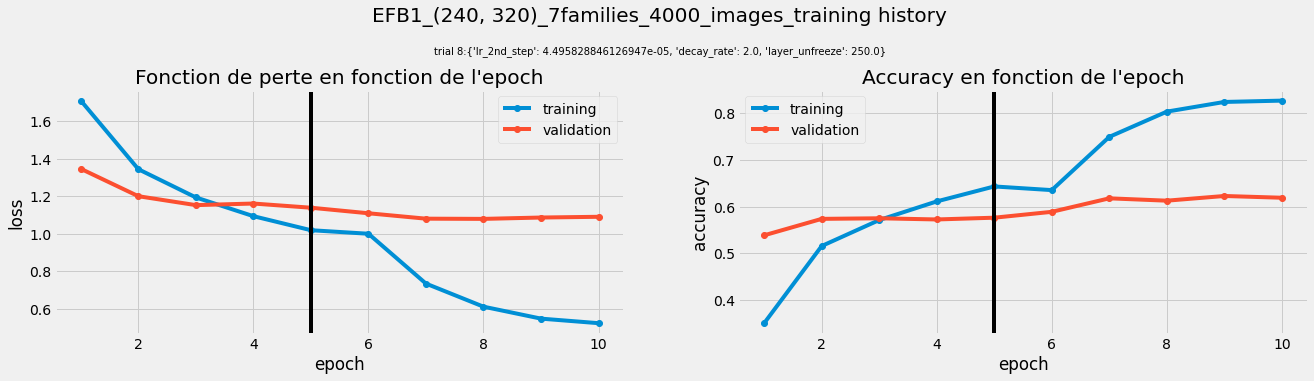

**************************************************TEST set classification report**************************************************


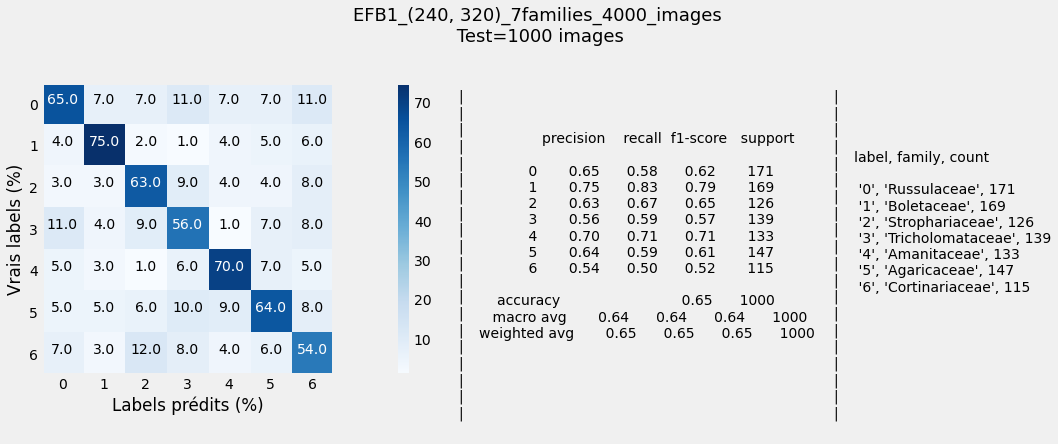

[I 2022-02-09 13:14:46,738] Trial 8 finished with value: 0.6187499761581421 and parameters: {'lr_2nd_step': 4.495828846126947e-05, 'decay_rate': 2.0, 'layer_unfreeze': 250.0}. Best is trial 6 with value: 0.6337500214576721.


************************************************************************************************************************
trial 9:{'lr_2nd_step': 6.105025964967256e-05, 'decay_rate': 3.0, 'layer_unfreeze': 340.0}
**************************************************setting base model trainable**************************************************
**************************************************setting base model trainable**************************************************
trainable_count = 8291271 / non_trainable_count =  124103
0.001
6.105025964967256e-05
lr=6.105026113800704e-05 / batch_size = 16
Epoch 6/15
200/200 [==============================] - ETA: 0s - loss: 1.0217 - accuracy: 0.6319

[I 2022-02-09 13:16:05,407] Trial 9 pruned. Trial was pruned at epoch 5.


************************************************************************************************************************
trial 10:{'lr_2nd_step': 5.064806366371031e-05, 'decay_rate': 6.0, 'layer_unfreeze': 280.0}
**************************************************setting base model trainable**************************************************
**************************************************setting base model trainable**************************************************
trainable_count = 8269393 / non_trainable_count =  145981
0.001
5.064806366371031e-05
lr=5.064806464361027e-05 / batch_size = 16
Epoch 6/15
200/200 [==============================] - 48s 189ms/step - loss: 1.0228 - accuracy: 0.6334 - val_loss: 1.1013 - val_accuracy: 0.5913 - lr: 5.0648e-05
Epoch 7/15
200/200 [==============================] - 36s 179ms/step - loss: 0.7043 - accuracy: 0.7731 - val_loss: 1.0519 - val_accuracy: 0.6025 - lr: 7.2354e-06
Epoch 8/15
200/200 [==============================] - 36s 179ms/step - loss:

[I 2022-02-09 13:19:30,989] Trial 10 pruned. Trial was pruned at epoch 9.


************************************************************************************************************************
trial 11:{'lr_2nd_step': 7.031752721982161e-06, 'decay_rate': 3.0, 'layer_unfreeze': 310.0}
**************************************************setting base model trainable**************************************************
**************************************************setting base model trainable**************************************************
trainable_count = 8288507 / non_trainable_count =  126867
0.001
7.031752721982161e-06
lr=7.031752829789184e-06 / batch_size = 16
Epoch 6/15
200/200 [==============================] - ETA: 0s - loss: 1.0125 - accuracy: 0.6516

[I 2022-02-09 13:20:34,040] Trial 11 pruned. Trial was pruned at epoch 5.


************************************************************************************************************************
trial 12:{'lr_2nd_step': 9.934216378011334e-05, 'decay_rate': 3.0, 'layer_unfreeze': 250.0}
**************************************************setting base model trainable**************************************************
**************************************************setting base model trainable**************************************************
trainable_count = 8238469 / non_trainable_count =  176905
0.001
9.934216378011334e-05
lr=9.934216359397396e-05 / batch_size = 16
Epoch 6/15
200/200 [==============================] - 41s 156ms/step - loss: 1.0826 - accuracy: 0.6128 - val_loss: 1.1590 - val_accuracy: 0.5838 - lr: 9.9342e-05
Epoch 7/15
200/200 [==============================] - 30s 148ms/step - loss: 0.6289 - accuracy: 0.7944 - val_loss: 1.0817 - val_accuracy: 0.6125 - lr: 2.4836e-05
Epoch 8/15
200/200 [==============================] - 29s 147ms/step - loss:

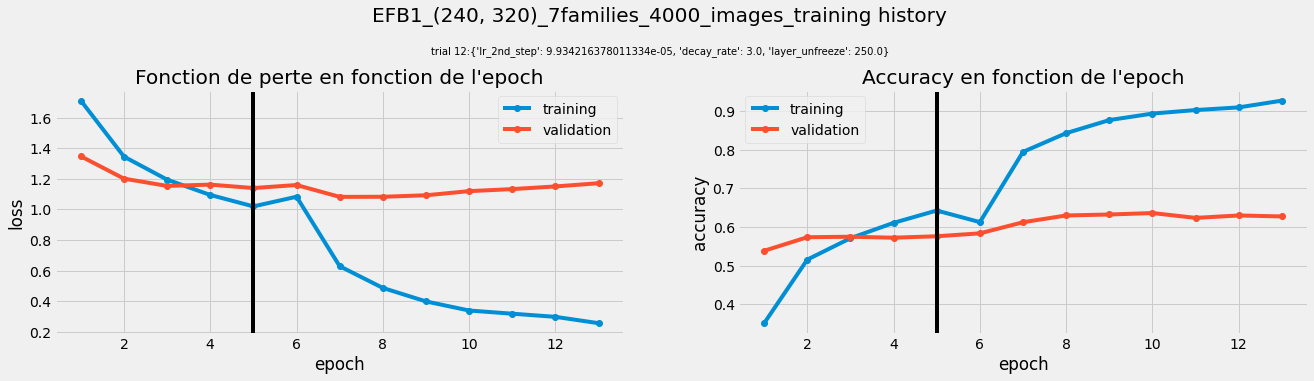

**************************************************TEST set classification report**************************************************


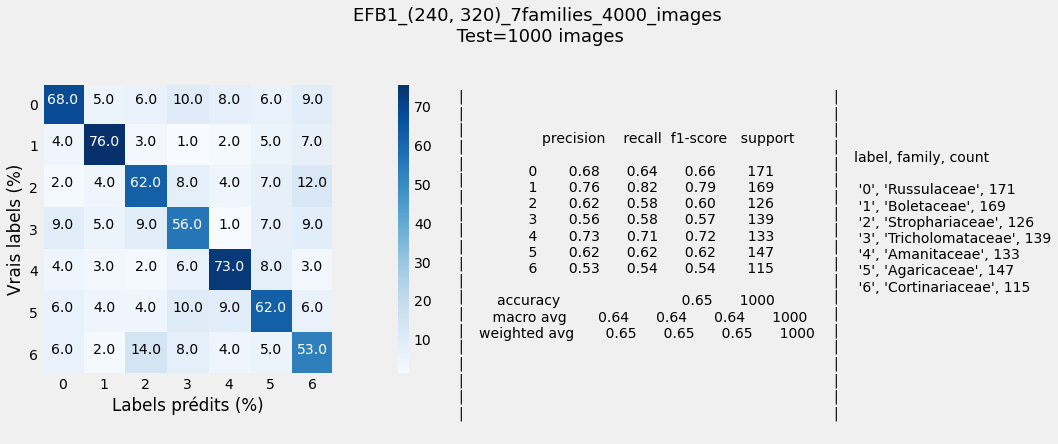

[I 2022-02-09 13:26:09,787] Trial 12 finished with value: 0.6274999976158142 and parameters: {'lr_2nd_step': 9.934216378011334e-05, 'decay_rate': 3.0, 'layer_unfreeze': 250.0}. Best is trial 6 with value: 0.6337500214576721.


************************************************************************************************************************
trial 13:{'lr_2nd_step': 5.9044640509938415e-05, 'decay_rate': 5.0, 'layer_unfreeze': 250.0}
**************************************************setting base model trainable**************************************************
**************************************************setting base model trainable**************************************************
trainable_count = 8238469 / non_trainable_count =  176905
0.001
5.9044640509938415e-05
lr=5.9044639783678576e-05 / batch_size = 16
Epoch 6/15
200/200 [==============================] - 41s 156ms/step - loss: 1.0153 - accuracy: 0.6416 - val_loss: 1.1240 - val_accuracy: 0.5788 - lr: 5.9045e-05
Epoch 7/15
200/200 [==============================] - 30s 148ms/step - loss: 0.6902 - accuracy: 0.7769 - val_loss: 1.0719 - val_accuracy: 0.6187 - lr: 9.8408e-06
Epoch 8/15
200/200 [==============================] - 29s 147ms/step - lo

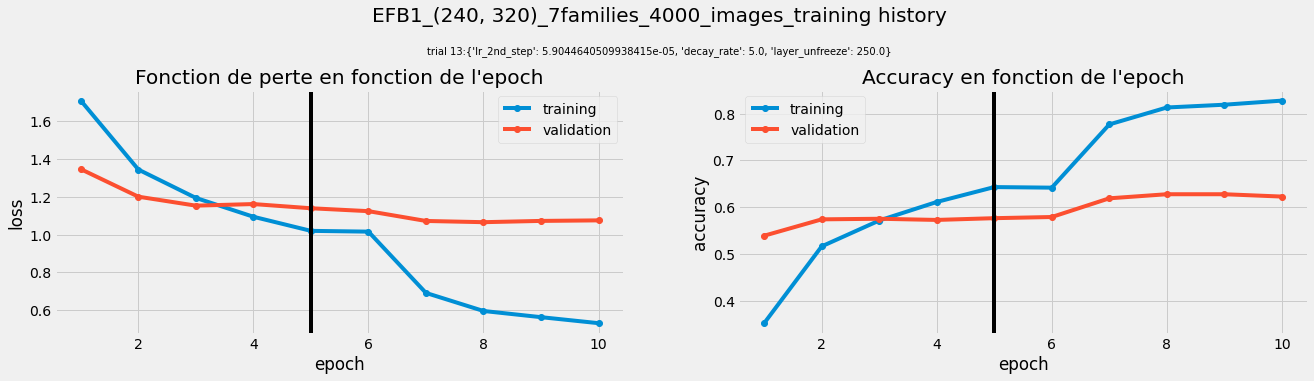

**************************************************TEST set classification report**************************************************


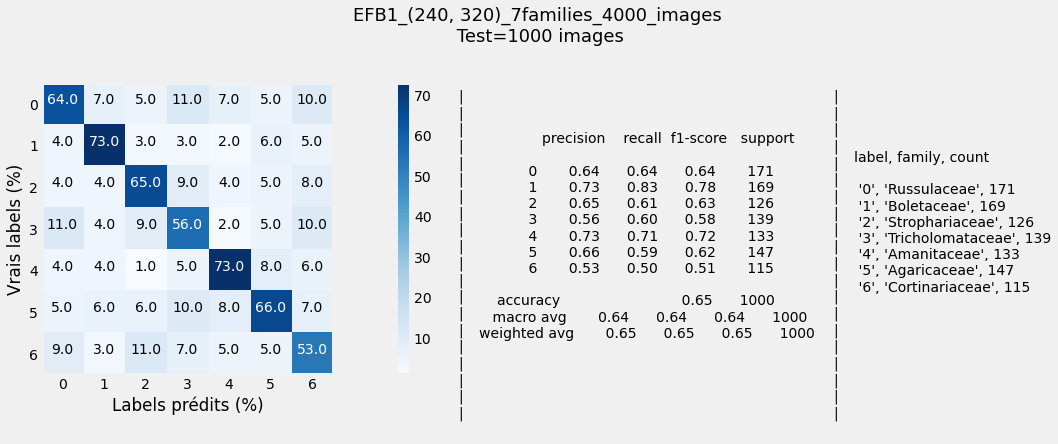

[I 2022-02-09 13:29:33,238] Trial 13 finished with value: 0.6225000023841858 and parameters: {'lr_2nd_step': 5.9044640509938415e-05, 'decay_rate': 5.0, 'layer_unfreeze': 250.0}. Best is trial 6 with value: 0.6337500214576721.


************************************************************************************************************************
trial 14:{'lr_2nd_step': 1.1997398080704499e-05, 'decay_rate': 7.0, 'layer_unfreeze': 310.0}
**************************************************setting base model trainable**************************************************
**************************************************setting base model trainable**************************************************
trainable_count = 8288507 / non_trainable_count =  126867
0.001
1.1997398080704499e-05
lr=1.1997398360108491e-05 / batch_size = 16
Epoch 6/15
200/200 [==============================] - 59s 243ms/step - loss: 1.0075 - accuracy: 0.6478 - val_loss: 1.1304 - val_accuracy: 0.5925 - lr: 1.1997e-05
Epoch 7/15
200/200 [==============================] - 47s 234ms/step - loss: 0.8500 - accuracy: 0.7097 - val_loss: 1.1222 - val_accuracy: 0.5863 - lr: 1.4997e-06
Epoch 8/15
200/200 [==============================] - 47s 233ms/step - lo

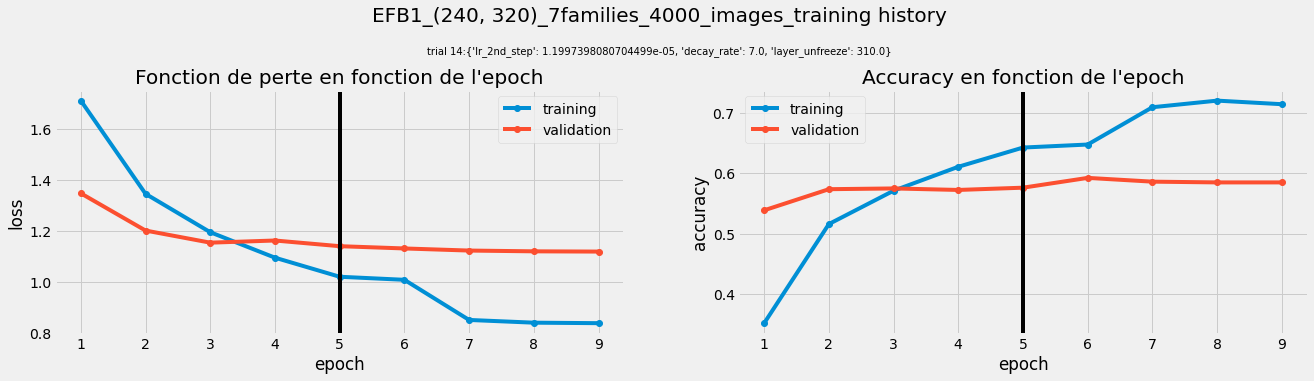

**************************************************TEST set classification report**************************************************


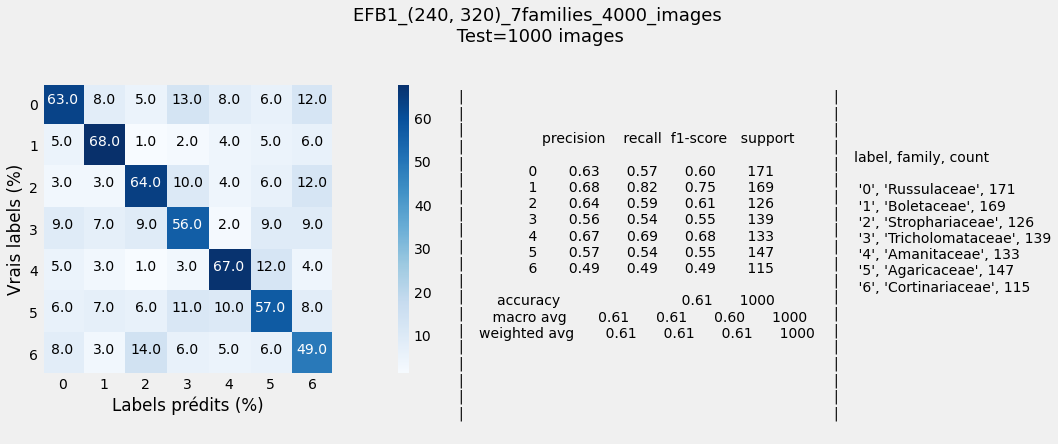

[I 2022-02-09 13:33:38,172] Trial 14 finished with value: 0.5849999785423279 and parameters: {'lr_2nd_step': 1.1997398080704499e-05, 'decay_rate': 7.0, 'layer_unfreeze': 310.0}. Best is trial 6 with value: 0.6337500214576721.


time: 46min 51s (started: 2022-02-09 12:46:47 +00:00)


In [45]:
# objective function 2nd step only: FC + variable layer number / lrscheduler 
epochs_2nd_step = 10
trial_metric = {}
def objective(trial):
  print('*'*120)
  # variables trial 
  # intial lr 2nd step 
  lr_2nd_step = trial.suggest_loguniform('lr_2nd_step',1e-6,1e-4) 
  # decay rate lrscheduler 
  decay_rate = trial.suggest_discrete_uniform('decay_rate',1,10,1) 
  # number of layer to defreeze 2nd step
  layer_number = int(trial.suggest_discrete_uniform('layer_unfreeze',250,340,30))
  layer_number = 339 if layer_number > 339 else layer_number #339 max efb1
  text = 'trial ' + str(trial.number) + ':' + str(trial.params)
  print(text)
  # Clear clutter from previous TensorFlow graphs.
  tf.keras.backend.clear_session()
  # Add a callback for pruning cf optuna 
  pruning_callback = optuna.integration.TFKerasPruningCallback(trial, "val_accuracy") # pruning sur le set d'evaluation 

  #### FINE TUNING STEP cf https://www.tensorflow.org/guide/keras/transfer_learning
  print("*"*50 + 'setting base model trainable' + '*'*50)
  model = keras.models.load_model("/model_end_previous_step.h5") # /model_first_step.h5
  print("*"*50 + 'setting base model trainable' + '*'*50)
  efB1_layers = model.get_layer(index=0) # get all efB1 layers when we load a model 
  for layer in efB1_layers.layers[-layer_number:]:
        layer.trainable = True  if not isinstance(layer, keras.layers.BatchNormalization) else False # batchnorm has to be freeze
  # check
  print('trainable_count = {} / non_trainable_count =  {}'.format(count_params(model.trainable_weights),count_params(model.non_trainable_weights)))
  # compile 2nd setp 
  model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
  # get last lr sinon il revient à 0.001 
  lr = K.eval(model.optimizer.lr)
  print(lr)
  lr = lr_2nd_step
  print(lr)
  K.set_value(model.optimizer.learning_rate, lr)
  # check
  print('lr={} / batch_size = {}'.format(K.eval(model.optimizer.lr),batch_size))
  # define last epoch number to keep up
  max_epoch_freeze = len(training_history_model_1.history['accuracy'])
  # setup lr scheduler 
  def scheduler(epoch):
    return lr * 1 / (1 + decay_rate * (epoch-max_epoch_freeze))
  LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
  # fine tuning step training 
  tic = time.time()
  training_history_model_2 = model.fit(train_generator,initial_epoch = max_epoch_freeze, # specify initial epoch 
                                  epochs=max_epoch_freeze + epochs_2nd_step,
                                  steps_per_epoch = len(df_train_)//batch_size,
                                  validation_data = val_generator,validation_steps = len(df_val_)//batch_size,
                                   class_weight=class_weights,
                                  callbacks=[
                                             early_stopping_step2,
                                            LearningRateScheduler,
                                            #  reduce_learning_rate, #KERAS
                                             pruning_callback # optuna 
                                             ],
                                  # use_multiprocessing = True,workers = 2 # pour warning tensorflow:Callback method on_train_batch_end is slow compared to the batch time
                                  )
  time_to_fit = tic - time.time()
  print('fite time = {}'.format(-round(time_to_fit/60,1)))
  # concat history 
  training_history_model_trial = {}
  for (k1,v1),(k2,v2) in zip(training_history_model_1.history.items(),training_history_model_2.history.items()):
    training_history_model_trial[k1] = v1 +v2 
  # Plot hIStory 
  training_history_fig = plot_history_2steps(training_history_model_trial,pathinfos,max_epoch_freeze)
  # # add trial infos
  training_history_fig.text(0.5,0.85,text ,ha= 'center',fontsize=10,wrap=True)
  display(training_history_fig)
  # save fig + model summary
  trial_infos =  '_trial' + str(trial.number)
  training_history_fig.savefig(export_dir + pathinfos +  trial_infos  +  '_training_history.jpeg' )
  with open(export_dir + pathinfos +  trial_infos  +  '_modelsummary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
  # on regarde ce que ça donne sur test set (normalement doit pas le faire)
  print("*"*50 + 'TEST set classification report' + '*'*50)
  # predict 
  y_prob = model.predict(test_generator,len(df_test)//batch_size)
  test_pred_class= np.argmax(y_prob , axis=1)
  # true label
  y_test_class= df_test['label'].values.astype(int)
  # report 
  # print(metrics.classification_report(y_test_class, test_pred_class))
  # save report
  report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)
  report = pd.DataFrame(report).transpose()
  report_path = export_dir + pathinfos +  trial_infos + '_classification report.csv'
  report.to_csv(report_path)
  # conf matrix 
  classes = df['gbif_info.family'].nunique()  # classes
  # label and count for legend 
  unique, counts = np.unique(y_test_class, return_counts=True)
  test_dict_label = pd.DataFrame(zip(unique.astype(str), counts), columns=['label','y_test_count'])
  test_dict_label = dict_label_df.merge(test_dict_label,on='label')
  test_dict_label = test_dict_label.drop(['size'], axis=1)
  # plot 
  conf_matrix_fig = conf_matrix_and_clasif_report(y_test_class , test_pred_class,classes,test_dict_label)
  display(conf_matrix_fig)
  # save fig 
  conf_matrix_fig.savefig(export_dir + pathinfos +  trial_infos +  '_conf_matrix.jpeg' ,bbox_inches = 'tight')
  # add other metric 
  trial_metric[trial_infos] = [training_history_model_trial['accuracy'][-1],
                                                 training_history_model_trial['val_accuracy'][-1],
                                                 accuracy_score(y_test_class , test_pred_class),
                                                  f1_score(y_test_class , test_pred_class,average='weighted'),
                                                  time_to_fit]
  return training_history_model_trial['val_accuracy'][-1]

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize',
                            pruner=optuna.pruners.HyperbandPruner()
                            # pruner=optuna.pruners.MedianPruner( n_startup_trials=1 )
                            ) 
study.optimize(objective, n_trials=n_trials,callbacks= [lambda study, trial: gc.collect(),
                                                        lambda study, trial: tf.keras.backend.clear_session()]) #cf https://stackoverflow.com/questions/64666917/optuna-memory-issues

In [46]:
# # objective function 2 steps + FC + variable layer number / lrscheduler 
# epochs_2nd_step = 25
# trial_metric = {}
# def objective2(trial):
#   print('*'*120)
#   # variables trial 
#   # decay rate lrscheduler 
#   decay_rate = trial.suggest_discrete_uniform('decay_rate', 0.1,2,0.2) 
#   # number of layer to defreeze 2nd step
#   layer_number = int(trial.suggest_discrete_uniform('layer_unfreeze',250,340,30))
#   layer_number = 339 if layer_number > 339 else layer_number #339 max efb1
#   text = 'trial ' + str(trial.number) + ':' + str(trial.params)
#   print(text)
#   # Clear clutter from previous TensorFlow graphs.
#   tf.keras.backend.clear_session()
#   # split train/val 
#   df_train_, df_val_= train_test_split(df_train, train_size=0.8, stratify =df_train['label'], random_state=random_seed)
#   # train datagenerator
#   train_data_generator = ImageDataGenerator(
#                                             # rotation_range= 0.1, #trial.suggest_discrete_uniform('rotation_range', 0.0,90,45),
#                                             # # width_shift_range=trial.suggest_discrete_uniform('width_shift_range', 0.0, 0.2,0.1),
#                                             # # height_shift_range=trial.suggest_discrete_uniform('height_shift_range', 0.0, 0.2,0.1),
#                                             # # shear_range=trial.suggest_discrete_uniform('shear_range=', 0.0, 0.2,0.1),
#                                             # # zoom_range=trial.suggest_discrete_uniform('zoom_range', 0.0, 0.2,0.1),
#                                             # horizontal_flip= True, # trial.suggest_categorical("horizontal_flip", [True,False]),
#                                             # vertical_flip= True # trial.suggest_categorical("vertical_flip", [True,False]),
#                                             # # fill_mode='nearest',
#                                           ) 
#   train_generator = train_data_generator.flow_from_dataframe(dataframe = df_train_, 
#                                                            x_col = "drive_file_path",y_col="label", 
#                                                            target_size=resol,batch_size=batch_size,class_mode='sparse')

#   #val datagenerator
#   val_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_val_,
#                                                          x_col = "drive_file_path",y_col="label", 
#                                                            target_size=resol,batch_size=batch_size,class_mode='sparse')
  
#   # base model layers 
#   model_name  = 'EFB1'
#   weights = 'imagenet' # trial.suggest_categorical("weights", [None,'imagenet'])
#   base_model =  tf.keras.applications.EfficientNetB1(input_shape=(resol[0], resol[1], 3),
#                                                      weights=weights,
#                                                      include_top=False)
#   # base_model =base_model 
#   global_average_layer = tf.keras.layers.GlobalAveragePooling2D() 
#   layers = [ base_model,  global_average_layer ]
#   # define a number of classifier layers 
#   layers.append(tf.keras.layers.Dense(units = n_units_1, activation = 'relu'))
#   layers.append(tf.keras.layers.Dropout(dropout_1))
#   layers.append(tf.keras.layers.Dense(units = n_units_2, activation = 'relu'))
#   layers.append(tf.keras.layers.Dropout(dropout_2))
#   # add predICTION layers 
#   layers.append(Dense(units = classes_count, activation = 'softmax'))
#   #freeze all layers 
#   for layer in base_model.layers:
#       layer.trainable = False # freeze dans un premier temps  
#   # build model        
#   model = tf.keras.Sequential(layers,name = model_name)
#   # optimizer 
#   optimizer = "adam" #  trial.suggest_categorical("optimizer", ["sgd", "adam"]) 
#   # compilation 
#   model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
#   K.set_value(model.optimizer.learning_rate, lr) #set learning rate 
#   print('lr={} / batch_size = {}'.format(lr,batch_size))
#   # Add a callback for pruning cf optuna 
#   pruning_callback = optuna.integration.TFKerasPruningCallback(trial, "val_accuracy") # pruning sur le set d'evaluation 
#   # csv start path infos 
#   pathinfos = str(model.name) + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(df_train)) + '_images'
#   ## Entraînement
#   model.summary()
#   tic = time.time()
#   training_history_model_1 = model.fit(train_generator,epochs=epochs,
#                                   steps_per_epoch = len(df_train_)//batch_size,
#                                   validation_data = val_generator,validation_steps = len(df_val_)//batch_size,
#                                    class_weight=class_weights,
#                                   callbacks=[
#                                              early_stopping_step1, # early stopping only 
#                                              ]) 
#   #### FINE TUNING STEP cf https://www.tensorflow.org/guide/keras/transfer_learning
#   print("*"*50 + 'setting base model trainable' + '*'*50)
#   efB1_layers = model.get_layer(index=0) # get all efB1 layers when we load a model 
#   for layer in efB1_layers.layers[-layer_number:]:
#         layer.trainable = True  if not isinstance(layer, keras.layers.BatchNormalization) else False # batchnorm has to be freeze
#   # check
#   print('trainable_count = {} / non_trainable_count =  {}'.format(count_params(model.trainable_weights),count_params(model.non_trainable_weights)))
#   # compile 2nd setp 
#   model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
#   # get last lr sinon il revient à 0.001 
#   K.set_value(model.optimizer.learning_rate, lr)
#   print('lr={} / batch_size = {}'.format(lr,batch_size))
#   # define last epoch number to keep up
#   max_epoch_freeze = len(training_history_model_1.history['accuracy'])
#   # setup lr scheduler 
#   def scheduler(epoch):
#     return lr * 1 / (1 + decay_rate * (epoch-max_epoch_freeze))
#   LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
#   # fine tuning step training 
#   training_history_model_2 = model.fit(train_generator,initial_epoch = max_epoch_freeze, # specify initial epoch 
#                                   epochs=max_epoch_freeze + epochs_2nd_step,
#                                   steps_per_epoch = len(df_train_)//batch_size,
#                                   validation_data = val_generator,validation_steps = len(df_val_)//batch_size,
#                                    class_weight=class_weights,
#                                   callbacks=[
#                                              early_stopping,
#                                             LearningRateScheduler,
#                                             #  reduce_learning_rate, #KERAS
#                                              pruning_callback # optuna 
#                                              ],
#                                   use_multiprocessing = True,workers = 2 # pour warning tensorflow:Callback method on_train_batch_end is slow compared to the batch time
#                                   )
#   time_to_fit = tic - time.time()
#   print('fite time = {}'.format(-round(time_to_fit/60,1)))
#   # concat history 
#   training_history_model = {}
#   for (k1,v1),(k2,v2) in zip(training_history_model_1.history.items(),training_history_model_2.history.items()):
#     training_history_model[k1] = v1 +v2 
#   # Plot hIStory 
#   training_history_fig = plot_history_2steps(training_history_model,pathinfos,max_epoch_freeze)
#   # # add trial infos
#   training_history_fig.text(0.5,0.85,text ,ha= 'center',fontsize=10,wrap=True)
#   display(training_history_fig)
#   # save fig + model summary
#   trial_infos =  '_trial' + str(trial.number)
#   training_history_fig.savefig(export_dir + pathinfos +  trial_infos  +  '_training_history.jpeg' )
#   with open(export_dir + pathinfos +  trial_infos  +  '_modelsummary.txt', 'w') as f:
#     model.summary(print_fn=lambda x: f.write(x + '\n'))
#   # on regarde ce que ça donne sur test set (normalement doit pas le faire)
#   print("*"*50 + 'TEST set classification report' + '*'*50)
#   #test datagenerator w/o shuffle 
#   test_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_test,
#                                                          x_col = "drive_file_path",y_col="label",shuffle=False,
#                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')
#   # predict 
#   y_prob = model.predict(test_generator,len(df_test)//batch_size)
#   test_pred_class= np.argmax(y_prob , axis=1)
#   # true label
#   y_test_class= df_test['label'].values.astype(int)
#   # report 
#   # print(metrics.classification_report(y_test_class, test_pred_class))
#   # save report
#   report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)
#   report = pd.DataFrame(report).transpose()
#   report_path = export_dir + pathinfos +  trial_infos + '_classification report.csv'
#   report.to_csv(report_path)
#   # conf matrix 
#   classes = df['gbif_info.family'].nunique()  # classes
#   # label and count for legend 
#   unique, counts = np.unique(y_test_class, return_counts=True)
#   test_dict_label = pd.DataFrame(zip(unique.astype(str), counts), columns=['label','y_test_count'])
#   test_dict_label = dict_label_df.merge(test_dict_label,on='label')
#   test_dict_label = test_dict_label.drop(['size'], axis=1)
#   # plot 
#   conf_matrix_fig = conf_matrix_and_clasif_report(y_test_class , test_pred_class,classes,test_dict_label)
#   display(conf_matrix_fig)
#   # save fig 
#   conf_matrix_fig.savefig(export_dir + pathinfos +  trial_infos +  '_conf_matrix.jpeg' ,bbox_inches = 'tight')
#   # add other metric 
#   trial_metric[trial_infos] = [training_history_model['accuracy'][-1],
#                                                  training_history_model['val_accuracy'][-1],
#                                                  accuracy_score(y_test_class , test_pred_class),
#                                                   f1_score(y_test_class , test_pred_class,average='weighted'),
#                                                   time_to_fit]
#   return training_history_model['val_accuracy'][-1]

# # 3. Create a study object and optimize the objective function.
# study = optuna.create_study(direction='maximize',
#                             pruner=optuna.pruners.HyperbandPruner()
#                             # pruner=optuna.pruners.MedianPruner( n_startup_trials=1 )
#                             ) 
# study.optimize(objective, n_trials=n_trials,callbacks= [lambda study, trial: gc.collect(),
#                                                         lambda study, trial: tf.keras.backend.clear_session()]) #cf https://stackoverflow.com/questions/64666917/optuna-memory-issues

time: 30.1 ms (started: 2022-02-09 13:33:39 +00:00)


In [47]:
# # EN FIXANT architecture à 2 couches denses + unfreeze at start 
# trial_metric = {}
# trial_number = 0
# def objective2(trial):
#   print('*'*120)
#   # Clear clutter from previous TensorFlow graphs.
#   tf.keras.backend.clear_session()
#   # split train/val 
#   df_train_, df_val_= train_test_split(df_train, train_size=0.8, stratify =df_train['label'], random_state=random_seed)
#   # train datagenerator
#   train_data_generator = ImageDataGenerator(
#                                             rotation_range=0.1, #trial.suggest_discrete_uniform('rotation_range', 0.0,0.2,0.1),
#                                             # # width_shift_range=trial.suggest_discrete_uniform('width_shift_range', 0.0, 0.2,0.1),
#                                             # # height_shift_range=trial.suggest_discrete_uniform('height_shift_range', 0.0, 0.2,0.1),
#                                             # # shear_range=trial.suggest_discrete_uniform('shear_range=', 0.0, 0.2,0.1),
#                                             # zoom_range=trial.suggest_discrete_uniform('zoom_range', 0.0, 0.2,0.1),
#                                             horizontal_flip= True, # trial.suggest_categorical("horizontal_flip", [True,False]),
#                                             vertical_flip= True # trial.suggest_categorical("vertical_flip", [True,False]),
#                                             # # fill_mode='nearest',
#                                           ) 
#   batch_size  =  16 # trial.suggest_categorical("batch_size", [16])
#   train_generator = train_data_generator.flow_from_dataframe(dataframe = df_train_, 
#                                                            x_col = "drive_file_path",y_col="label", 
#                                                            target_size=resol,batch_size=batch_size,class_mode='sparse')

#   #val datagenerator
#   val_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_val_,
#                                                          x_col = "drive_file_path",y_col="label", 
#                                                            target_size=resol,batch_size=batch_size,class_mode='sparse')
  
#   # base model layers 
#   model_name  = 'EFB1'
#   weights = 'imagenet' # trial.suggest_categorical("weights", [None,'imagenet'])
#   base_model =  tf.keras.applications.EfficientNetB1(input_shape=(resol[0], resol[1], 3),
#                                                      weights=weights,
#                                                      include_top=False)
#   # base_model =base_model 
#   global_average_layer = tf.keras.layers.GlobalAveragePooling2D() 
#   layers = [ base_model,  global_average_layer ]
#   # define a number of classifier layers 
#   layers.append(tf.keras.layers.Dense(units = 1024, activation = 'relu')) # trial.suggest_categorical("num_units_0", [32, 64, 128, 256, 512,1024,2048])
#   layers.append(tf.keras.layers.Dropout(trial.suggest_discrete_uniform('dropout_rate_0', 0.0, 0.8,0.1)))
#   layers.append(tf.keras.layers.Dense(units = 512, activation = 'relu')) #  trial.suggest_categorical("num_units_1", [32, 64, 128, 256, 512,1024,2048]
#   layers.append(tf.keras.layers.Dropout(trial.suggest_discrete_uniform('dropout_rate_1', 0.0, 0.8,0.1)))
#   # add predICTION layers 
#   layers.append(Dense(units = classes_count, activation = 'softmax'))
#   #freeze/unfreeze all layers 
#   for layer in base_model.layers:
#       layer.trainable = False # unfreeze at start   
#   # build model        
#   model = tf.keras.Sequential(layers,name = model_name)
#   # optimizer 
#   optimizer = "adam" #  trial.suggest_categorical("optimizer", ["sgd", "adam"]) 
#   lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
#   # compilation 
#   model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
#   K.set_value(model.optimizer.learning_rate, lr) #set learning rate 
#   # Add a callback for pruning cf optuna 
#   pruning_callback = optuna.integration.TFKerasPruningCallback(trial, "val_accuracy") # pruning sur le set d'evaluation 
#   # csv start path infos 
#   pathinfos = str(model.name) + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(df_train)) + '_images'
#   ## Entraînement
#   text = 'trial ' + str(trial.number) + ':' + str(trial.params)
#   t1, t2 = text[:len(text)//2],text[len(text)//2:]
#   print(t1 + '\n' + t2)
#   model.summary()

#   tic = time.time() 
#   training_history_model_1 = model.fit(train_generator,epochs=epochs,
#                                   steps_per_epoch = len(df_train_)//batch_size,
#                                   validation_data = val_generator,validation_steps = len(df_val_)//batch_size,
#                                    class_weight=class_weights,
#                                   callbacks=[
#                                              early_stopping_step1,
#                                             #  reduce_learning_rate,  # pas dans un prmeier temps 
#                                              pruning_callback # optuna 
#                                              ],
#                                   # use_multiprocessing = True,workers = 2 # pour warning tensorflow:Callback method on_train_batch_end is slow compared to the batch time
#                                   ) 
#   #### FINE TUNING STEP cf https://www.tensorflow.org/guide/keras/transfer_learning
#   print("*"*50 + 'setting base model trainable' + '*'*50)
#   for layer in base_model.layers:
#       layer.trainable = True  if not isinstance(layer, keras.layers.BatchNormalization) else False # batchnorm has to be freeze
#   # check 
#   print('trainable_count = {} / non_trainable_count =  {}'.format(count_params(model.trainable_weights),count_params(model.non_trainable_weights)))
#   model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
#   # get last lr sinon il revient à 0.001
#   # lr = training_history_model_1.history['lr'][-1] # pas dispo si callback absent 
#   K.set_value(model.optimizer.learning_rate, lr) #set learning rate faible => pas necessaire car le callback a déjà réduit le lr 
#   # define last epoch number to keep up
#   max_epoch_freeze = len(training_history_model_1.history['accuracy'])
#   # fine tuning 
#   training_history_model_2 = model.fit(train_generator,initial_epoch = max_epoch_freeze, # specify initial epoch 
#                                   epochs=max_epoch_freeze + 10,
#                                   steps_per_epoch = len(df_train_)//batch_size,
#                                   validation_data = val_generator,validation_steps = len(df_val_)//batch_size,
#                                    class_weight=class_weights,
#                                   callbacks=[
#                                              early_stopping,reduce_learning_rate, #KERAS
#                                              pruning_callback # optuna 
#                                              ],
#                                   use_multiprocessing = True,workers = 2 # pour warning tensorflow:Callback method on_train_batch_end is slow compared to the batch time
#                                   )
#   # Plot hIStory 
#   time_to_fit = tic - time.time()
#   print('fite time = {}'.format(-round(time_to_fit/60,1)))
#   # concat history 
#   training_history_model = {}
#   for (k1,v1),(k2,v2) in zip(training_history_model_1.history.items(),training_history_model_2.history.items()):
#     training_history_model[k1] = v1 +v2 
#   # training_history_model = training_history_model.history

#   # Plot hIStory 
#   training_history_fig = plot_history_2steps(training_history_model,pathinfos,max_epoch_freeze)
#   # # add trial infos
#   training_history_fig.text(0.5,0.85,t1 + '\n' + t2 ,ha= 'center',fontsize=10,wrap=True)
#   display(training_history_fig)
#   # save fig + model summary
#   trial_infos =  '_trial' + str(trial.number)
#   training_history_fig.savefig(export_dir + pathinfos +  trial_infos  +  '_training_history.jpeg' )
#   with open(export_dir + pathinfos +  trial_infos  +  '_modelsummary.txt', 'w') as f:
#     model.summary(print_fn=lambda x: f.write(x + '\n'))
#   # on regarde ce que ça donne sur test set (normalement doit pas le faire)
#   print("*"*50 + 'TEST set classification report' + '*'*50)
#   #test datagenerator w/o shuffle 
#   test_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_test,
#                                                          x_col = "drive_file_path",y_col="label",shuffle=False,
#                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')
#   # predict 
#   y_prob = model.predict(test_generator,len(df_test)//batch_size)
#   test_pred_class= np.argmax(y_prob , axis=1)
#   # true label
#   y_test_class= df_test['label'].values.astype(int)
#   # report 
#   # print(metrics.classification_report(y_test_class, test_pred_class))
#   # save report
#   report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)
#   report = pd.DataFrame(report).transpose()
#   report_path = export_dir + pathinfos +  trial_infos + '_classification report.csv'
#   report.to_csv(report_path)
#   # conf matrix 
#   classes = df['gbif_info.family'].nunique()  # classes
#   # label and count for legend 
#   unique, counts = np.unique(y_test_class, return_counts=True)
#   test_dict_label = pd.DataFrame(zip(unique.astype(str), counts), columns=['label','y_test_count'])
#   test_dict_label = dict_label_df.merge(test_dict_label,on='label')
#   test_dict_label = test_dict_label.drop(['size'], axis=1)
#   # plot 
#   conf_matrix_fig = conf_matrix_and_clasif_report(y_test_class , test_pred_class,classes,test_dict_label)
#   display(conf_matrix_fig)
#   # save fig 
#   conf_matrix_fig.savefig(export_dir + pathinfos +  trial_infos +  '_conf_matrix.jpeg' ,bbox_inches = 'tight')
#   # add other metric 
#   trial_metric[trial_infos] = [training_history_model['accuracy'][-1],
#                                                  training_history_model['val_accuracy'][-1],
#                                                  accuracy_score(y_test_class , test_pred_class),
#                                                   f1_score(y_test_class , test_pred_class,average='weighted'),
#                                                    time_to_fit 
#                                ]
#   return training_history_model['val_accuracy'][-1]

# # 3. Create a study object and optimize the objective function.
# study = optuna.create_study(direction='maximize',
#                             pruner=optuna.pruners.HyperbandPruner()
#                             # pruner=optuna.pruners.MedianPruner( n_startup_trials=1 )
#                             ) 
# study.optimize(objective2, n_trials=n_trials,)

time: 25.8 ms (started: 2022-02-09 13:33:39 +00:00)


In [48]:
trial_df = study.trials_dataframe()
display(trial_df)
trial_df.to_csv(export_dir + 'optuna_trials.csv')

number    value  ... system_attrs_completed_rung_2     state
0        0  0.56625  ...                           NaN  COMPLETE
1        1  0.58250  ...                           NaN  COMPLETE
2        2  0.57750  ...                           NaN  COMPLETE
3        3  0.56750  ...                           NaN    PRUNED
4        4  0.57500  ...                           NaN    PRUNED
5        5  0.55625  ...                           NaN    PRUNED
6        6  0.63375  ...                       0.63375  COMPLETE
7        7  0.58250  ...                           NaN    PRUNED
8        8  0.61875  ...                           NaN  COMPLETE
9        9  0.58250  ...                           NaN    PRUNED
10      10  0.61375  ...                       0.61375    PRUNED
11      11  0.58250  ...                           NaN    PRUNED
12      12  0.62750  ...                           NaN  COMPLETE
13      13  0.62250  ...                           NaN  COMPLETE
14      14  0.58500  ...                           NaN  COMPLETE

[15 rows x 12 columns]

time: 39 ms (started: 2022-02-09 13:33:39 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  """Entry point for launching an IPython kernel.


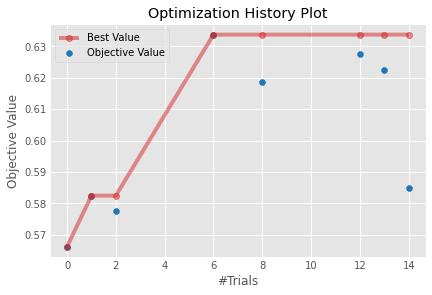

time: 322 ms (started: 2022-02-09 13:33:39 +00:00)


In [49]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)
plt.savefig(export_dir + pathinfos +  '_plot_optimization_history.jpeg',bbox_inches='tight'  )

In [50]:
fig = optuna.visualization.plot_intermediate_values(study)
plt.savefig(export_dir + pathinfos +  '_plot_intermediate_values.jpeg' )

<Figure size 432x288 with 0 Axes>

time: 51.4 ms (started: 2022-02-09 13:33:39 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ExperimentalWarning:

plot_slice is experimental (supported from v2.2.0). The interface can change in the future.



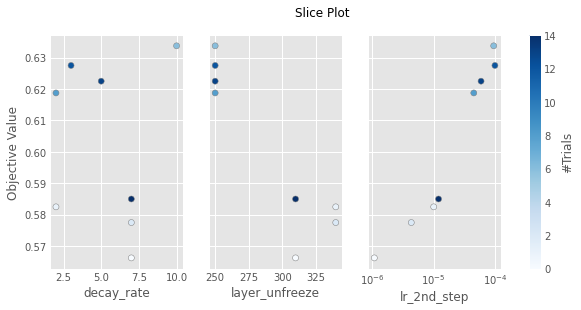

time: 1.16 s (started: 2022-02-09 13:33:39 +00:00)


In [51]:
fig = optuna.visualization.matplotlib.plot_slice(study)
plt.savefig(export_dir + pathinfos +  '_plot_slice.jpeg',bbox_inches='tight' )

In [52]:
# optuna.visualization.plot_parallel_coordinate(study)

time: 1.09 ms (started: 2022-02-09 13:33:41 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



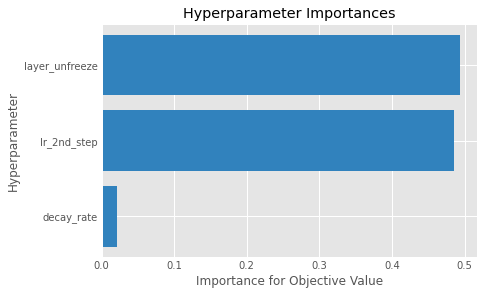

time: 429 ms (started: 2022-02-09 13:33:41 +00:00)


In [53]:
#Visualize parameter importances.
fig = optuna.visualization.matplotlib.plot_param_importances(study)
plt.savefig(export_dir + pathinfos +  '_plot_param_importances.jpeg' ,bbox_inches='tight' )

In [54]:
print('Best trial is number {}: score {},\nparams {}'.format(study.best_trial.number,study.best_trial.value,study.best_trial.params))

Best trial is number 6: score 0.6337500214576721,
params {'lr_2nd_step': 9.482337236420842e-05, 'decay_rate': 10.0, 'layer_unfreeze': 250.0}
time: 3.21 ms (started: 2022-02-09 13:33:41 +00:00)


In [55]:
study.best_trial.params

{'decay_rate': 10.0,
 'layer_unfreeze': 250.0,
 'lr_2nd_step': 9.482337236420842e-05}

time: 3.77 ms (started: 2022-02-09 13:33:41 +00:00)


# Best trials

In [56]:
columns_name = ['accuracy','val_accuracy','test_accuracy','weighted_f1','fit_time']
trials_metric_df = pd.DataFrame.from_dict(trial_metric, orient='index', columns = columns_name)
trials_metric_df = trials_metric_df.sort_values(by='val_accuracy', ascending = False) 
trials_metric_df 

accuracy  val_accuracy  test_accuracy  weighted_f1    fit_time
_trial6   0.841875       0.63375          0.649     0.647593 -202.516069
_trial12  0.926875       0.62750          0.651     0.650198 -313.985999
_trial13  0.827812       0.62250          0.649     0.647221 -182.035412
_trial8   0.825625       0.61875          0.647     0.645061 -191.018969
_trial14  0.714688       0.58500          0.613     0.609992 -234.607930
_trial1   0.720000       0.58250          0.612     0.608485 -317.020510
_trial2   0.680938       0.57750          0.603     0.600231 -317.084009
_trial0   0.633438       0.56625          0.573     0.570097 -301.314893

time: 20 ms (started: 2022-02-09 13:33:41 +00:00)


In [57]:
top3 = list(trials_metric_df.index[0:3])
# top3 = [trial_name.replace('_','') for trial_name in top3]


time: 711 µs (started: 2022-02-09 13:33:41 +00:00)


In [58]:
for trial_infos  in top3:
  print('_'*50+trial_infos+'_'*50)
  f = open(export_dir + pathinfos +  trial_infos  +  '_modelsummary.txt', "r")
  print(f.read())

___________________________________________________trial6__________________________________________________
Model: "EFB1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 8, 10, 1280)      6575239   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)

___________________________________________________trial6__________________________________________________


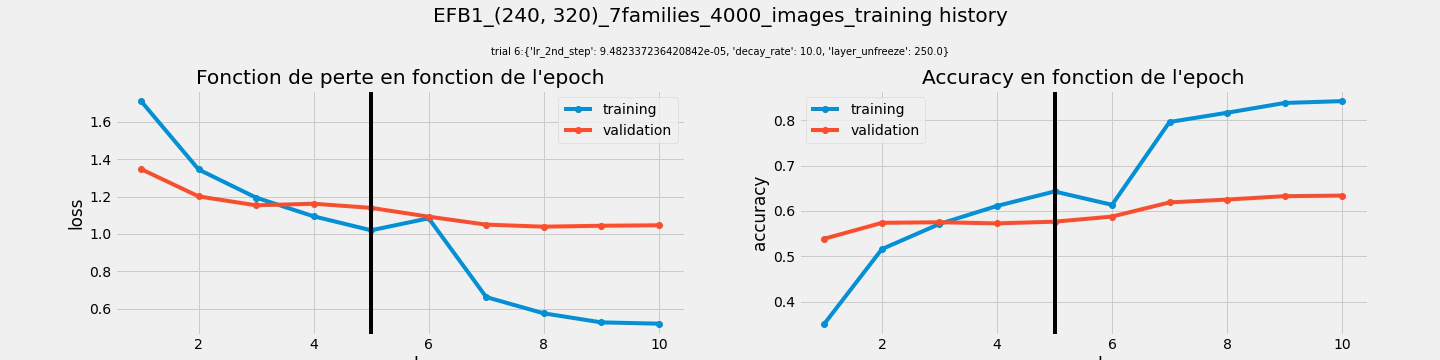

___________________________________________________trial12__________________________________________________


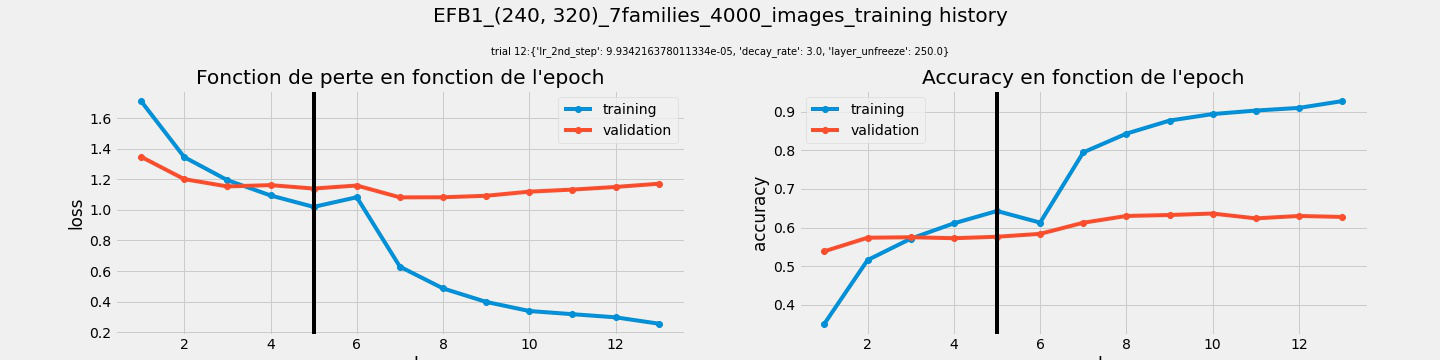

___________________________________________________trial13__________________________________________________


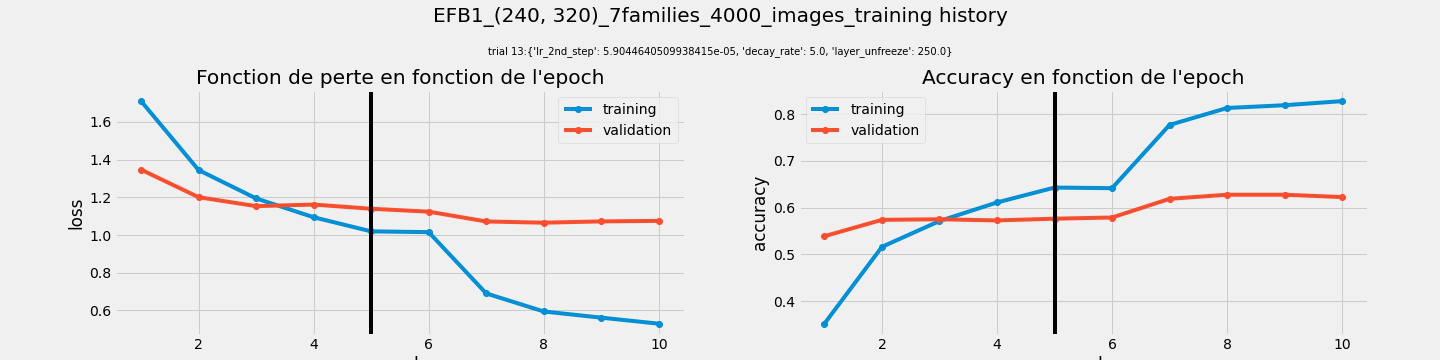

time: 218 ms (started: 2022-02-09 13:33:41 +00:00)


In [59]:
for trial_infos  in top3:
  print('_'*50+trial_infos+'_'*50)
  training_history = Image.open(export_dir + pathinfos +  trial_infos  +  '_training_history.jpeg')
  display(training_history)

___________________________________________________trial6__________________________________________________


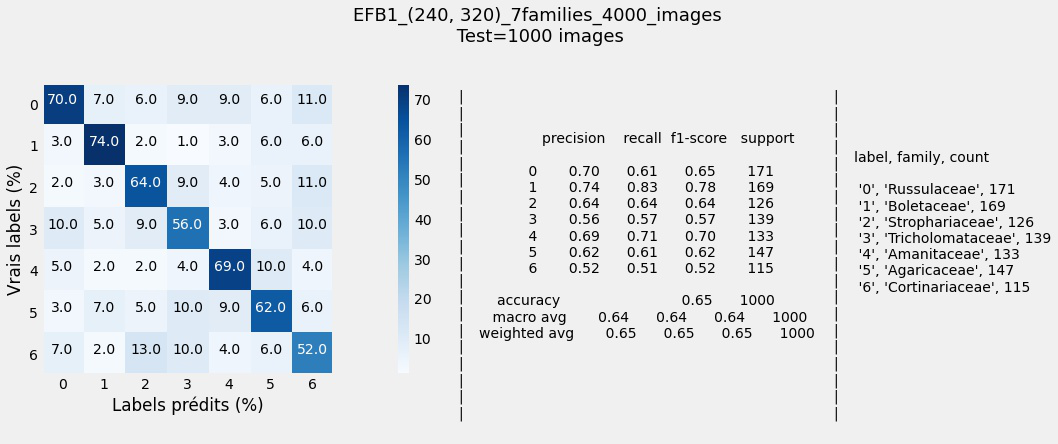

___________________________________________________trial12__________________________________________________


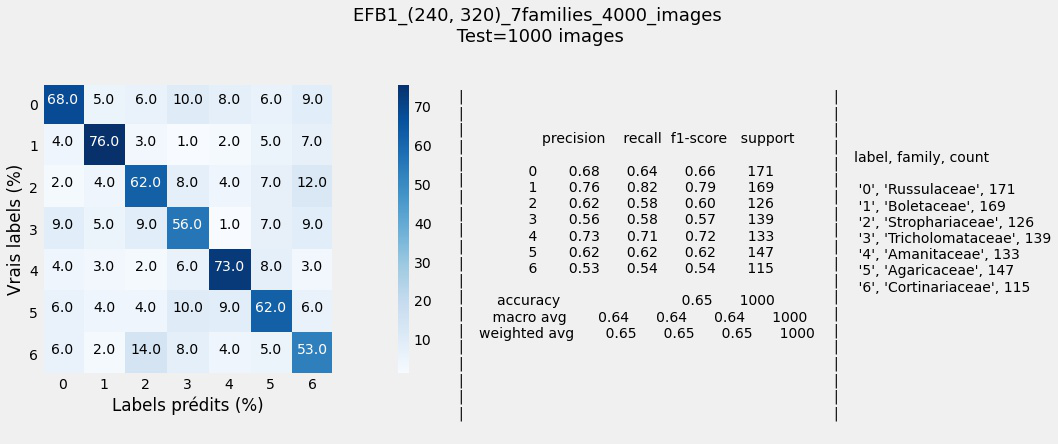

___________________________________________________trial13__________________________________________________


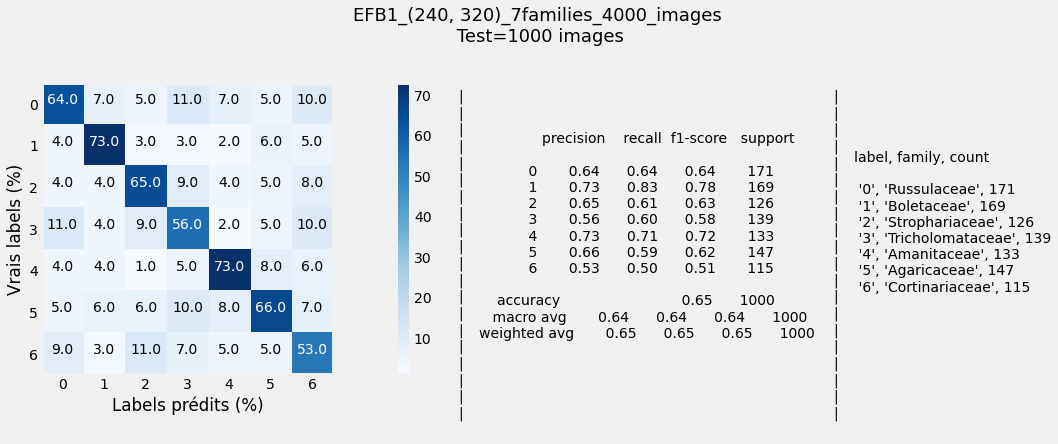

time: 278 ms (started: 2022-02-09 13:33:41 +00:00)


In [60]:
for trial_infos  in top3:
  print('_'*50+trial_infos+'_'*50)
  training_history = Image.open(export_dir + pathinfos +  trial_infos +  '_conf_matrix.jpeg' )
  display(training_history)

In [61]:
print('train/val/test acc = {}/{}/{} - f1 = {} in folder {} in {} s'.format(round(trials_metric_df.iloc[0]['accuracy'],2),
                                                                          round(trials_metric_df.iloc[0]['val_accuracy'],2),
                                                                          round(trials_metric_df.iloc[0]['test_accuracy'],2),
                                                                          round(trials_metric_df.iloc[0]['weighted_f1'],2),
                                                                          export_dir,
                                                                          -round(trials_metric_df.iloc[0]['fit_time'],0)  

    
                                                                              ))

train/val/test acc = 0.84/0.63/0.65 - f1 = 0.65 in folder /content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220209_12H44/ in 203.0 s
time: 7.72 ms (started: 2022-02-09 13:33:42 +00:00)


In [ ]:
# à la fin car very long 
from matplotlib import rcParams
rcParams['figure.figsize'] = 25,15
optuna.visualization.matplotlib.plot_contour(study) #DEBUG,['num_units_0','lr']
plt.savefig(export_dir + pathinfos +  '_plot_contour.jpeg' ,bbox_inches='tight' )
rcParams['figure.figsize'] = 6.4, 4.8 #reset to default 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ExperimentalWarning:

plot_contour is experimental (supported from v2.2.0). The interface can change in the future.

[W 2022-02-09 13:33:42,089] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


# QUESTIONS 

- batch normalisation layers ? role , fonctionnement ? 
- Quand sont resettés les weigths in a for loop ? 
- use_multiprocessing = True,workers = 2

In [ ]:
# !kill -9 -1